In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("/Users/wilka/git/research/jaxneurorl")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl/projects/humansf/analysis
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [3]:
# !pip install google-cloud-storage
# !pip install git+https://github.com/wcarvalho/nicewebrl --no-deps
# !pip install ipywidgets
# !pip install polars
# !pip install nicegui

In [4]:
import jax
import jax.numpy as jnp
import functools
from functools import partial
import pandas as pd
import numpy as np
from pprint import pprint
import glob
from glob import glob
import matplotlib.pyplot as plt
import polars as pl
from tqdm.notebook import tqdm

from projects.humansf import data_loading
from projects.humansf import housemaze_analysis
from projects.humansf import data_loading
from projects.humansf import housemaze_trainer
from projects.humansf import housemaze_experiments
from projects.humansf import networks
from projects.humansf import dataframe
from housemaze.human_dyna import mazes

from housemaze import renderer
from housemaze import utils
from housemaze.human_dyna import multitask_env as maze
from jaxneurorl import launcher
from jaxneurorl.agents import value_based_basics as vbb


from projects.humansf import download_data

No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.
/Users/wilka/miniforge3/envs/jaxneurorl/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:145: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


In [5]:
# data_dir = '/n/holylfs06/LABS/kempner_fellow_wcarvalho/results/jaxrl_result/housemaze_trainer'
data_dir = '/Users/wilka/git/research/results/human_dyna'

In [6]:
# experiments = [
#    'exp1_block1',
#    'exp1_block2',
#    'exp1_block3',
#    'exp1_block4',
# ]
dummy_env_params = housemaze_analysis.get_params(mazes.big_practice_maze)
dummy_rng = jax.random.PRNGKey(42)
task_runner = maze.TaskRunner(task_objects=housemaze_analysis.task_objects)
env = maze.HouseMaze(
    task_runner=task_runner,
    num_categories=500,
)
env = utils.AutoResetWrapper(env)
nenvs=25
example_timestep = env.reset(dummy_rng, dummy_env_params)

# Setup databases

For every algorithm, for every experiment, we will
1. load the algorithm
2. collect K=100 episodes for that algorithm on task objects, we can choose multiple or 1 task object. 
    we'll always use the 1st task object from the train and test sets
3. for each of these K episodes, we're going to create an entry inside a polars dataframe including (1) whether eval or not, (2) algorithm (3) experiment (4) room (5) task_idx

We'll want to options
1. if we reload this script, if possible load (a) algorithm df and (b) algorithm episodes from trajectory and don't recompute
3. option to force recomputation and overwrite data on disk


In the end, we'll have dfs for every algorithm and an episode dict which goes (alg:list). we'll use these to two subselect data for different algorithms. we'll write a small select function which takes in this merged df and this episode dict




We'll want to re-do this for users\

In [7]:
# !ls ~/git/research/results/human_dyna/model_data/*/save_data/*/*/*/analysis

In [8]:
# !rm -r ~/git/research/results/human_dyna/model_data/*/save_data/*/*/*/analysis

In [9]:
model_df_list = []
model_episodes_list = []


### Q-learning

In [10]:
exp = 'exp2'
qlearning_dir = download_data.qlearning_dir
paths = f'{data_dir}/model_data/{qlearning_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='qlearning',
        make_fns=functools.partial(
            housemaze_trainer.get_qlearning_fns,
            num_categories=10000),
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs,
    )
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)
    


  0%|          | 0/5 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""qlearning""","""exp2""",0,26,"""big_m1_maze3_shortcut""",3
true,"""qlearning""","""exp2""",0,40,"""big_m1_maze3_shortcut""",3
false,"""qlearning""","""exp2""",0,26,"""big_m2_maze2_offpath""",3
true,"""qlearning""","""exp2""",0,40,"""big_m2_maze2_offpath""",3
false,"""qlearning""","""exp2""",0,26,"""big_m3_maze1""",3


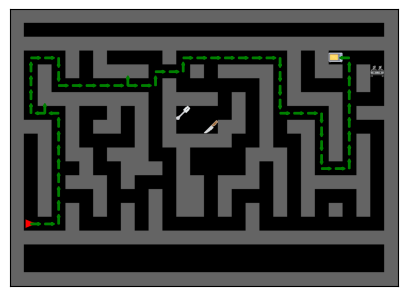

In [11]:
def first(eps): return jax.tree_map(lambda x:x[0], eps)
housemaze_analysis.render_path(first(episodes[0]))
df.head()

### Dyna-Q

In [12]:
exp = 'exp2'
# dyna_dir = f'ql/save_data/ql-21/exp={exp}'
dyna_dir = download_data.dyna_dir
paths = f'{data_dir}/model_data/{dyna_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='dynaq_shared',
        make_fns=functools.partial(housemaze_trainer.get_dynaq_fns,
            env=env,
            env_params=dummy_env_params,
            task_objects=housemaze_analysis.task_objects),
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs)
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)



  0%|          | 0/2 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""dynaq_shared""","""exp2""",0,26,"""big_m1_maze3_shortcut""",2
true,"""dynaq_shared""","""exp2""",0,40,"""big_m1_maze3_shortcut""",2
false,"""dynaq_shared""","""exp2""",0,26,"""big_m2_maze2_offpath""",2
true,"""dynaq_shared""","""exp2""",0,40,"""big_m2_maze2_offpath""",2
false,"""dynaq_shared""","""exp2""",0,26,"""big_m3_maze1""",2


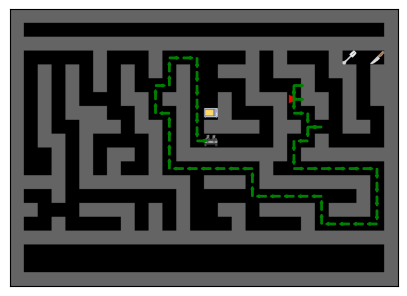

In [13]:
housemaze_analysis.render_path(first(episodes[-1]))
df.head()

### BFS/DFS

In [14]:
for algorithm in ['bfs', 'dfs']:
    df, episodes = housemaze_analysis.get_search_data(
        algorithm=algorithm,
        env=env,
        exp='exp2',
        base_path=f'{data_dir}/search_algos',
        budget=None,
        overwrite=False,
        searches=10,
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


eval,algo,exp,room,task,budget,maze_name
bool,str,str,i64,i64,str,str
false,"""dfs""","""exp2""",0,26,null,"""big_m1_maze3_shortcut"""
true,"""dfs""","""exp2""",0,40,null,"""big_m1_maze3_shortcut"""
false,"""dfs""","""exp2""",0,26,null,"""big_m2_maze2_offpath"""
true,"""dfs""","""exp2""",0,40,null,"""big_m2_maze2_offpath"""
false,"""dfs""","""exp2""",0,26,null,"""big_m3_maze1"""


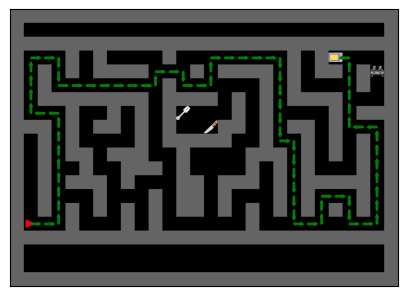

In [15]:
housemaze_analysis.render_path(first(episodes[0]))
df.head()

## put all model things together now

In [16]:
model_df = (
    pl.concat(model_df_list, how="diagonal_relaxed")
    .with_row_count(name="row_number")
    .with_columns(
        pl.col("row_number").alias("index")
    )
    .drop("row_number")
)
model_df = dataframe.EpisodeDataFrame(
    df=model_df,
    episodes=model_episodes_list,
)
model_df.head()

/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_72764/3541202562.py:2: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  pl.concat(model_df_list, how="diagonal_relaxed")


eval,algo,exp,room,task,maze_name,seed,budget,index
bool,str,str,i64,i64,str,i64,str,u32
false,"""qlearning""","""exp2""",0,26,"""big_m1_maze3_shortcut""",1,null,0
true,"""qlearning""","""exp2""",0,40,"""big_m1_maze3_shortcut""",1,null,1
false,"""qlearning""","""exp2""",0,26,"""big_m2_maze2_offpath""",1,null,2
true,"""qlearning""","""exp2""",0,40,"""big_m2_maze2_offpath""",1,null,3
false,"""qlearning""","""exp2""",0,26,"""big_m3_maze1""",1,null,4


# Human data

In [17]:
# from projects.humansf.download_data import download_user_files

# bucket_name = "human-dyna"
# prefix = "data/"
# #pattern = "data/data_user=*_name=r0-v2*debug=0.json"
# human_data_pattern = "data/data_user=*r0-exp2-obj1-v0*debug=0.json"
# destination_folder = "/Users/wilka/git/research/results/human_dyna/user_data/exp2"

# download_user_files(bucket_name, prefix, human_data_pattern, destination_folder)

In [18]:
# !ls -lhtr ~/git/research/results/human_dyna/user_data/exp2*

In [19]:
# !rm ~/git/research/results/human_dyna/user_data/*3714894224_name* ~/git/research/results/human_dyna/user_data/*2631242498_name*

In [20]:
data_dir = '/Users/wilka/git/research/results/human_dyna/'
files = f'{data_dir}/user_data/exp2/*obj1*v1*.json'
user_base_path = f'{data_dir}/user_data'
files = glob(files)
len(files)

32

In [21]:
import json
nfinished = 0
for idx, file in enumerate(files[4:]):
    with open(file, 'r') as f:
        try:
            data = json.load(f)
        except Exception as e:
            print('-'*25)
            print(idx, os.path.basename(file))
            print(e)
            continue
        finished = data[-1].get("finished", False)
        if finished:
            nfinished += 1
            print('-'*25)
            print(idx, os.path.basename(file))
            print(data[-1]['feedback'] or "NO FEEDBACK")
        # else:
        #     print("NOT FINISHED")

-------------------------
2 data_user=2672838701_name=r0-exp2-obj1-v1_exp=2_debug=0.json
NO FEEDBACK
-------------------------
4 data_user=2958212813_name=r0-exp2-obj1-v1_exp=2_debug=0.json
Thank you,
-------------------------
5 data_user=444968707_name=r0-exp2-obj1-v1_exp=2_debug=0.json
The movement of the arrow was unresponsive and caused me to make mistakes.
-------------------------
6 data_user=606867615_name=r0-exp2-obj1-v1_exp=2_debug=0.json
it was so laggy and hard to control
-------------------------
7 data_user=3786090989_name=r0-exp2-obj1-v1_exp=2_debug=0.json
NO FEEDBACK
-------------------------
9 data_user=1921995450_name=r0-exp2-obj1-v1_exp=2_debug=0.json
God this was terrible, to the point of being exploitative. What's wrong with this lab??  Anyway, the "experiment" screwed up the first time, randomly, requiring restarting. Then, the controls were crappy; didn't register arrow presses, and then the 'runner' would jump to a different position (after input lag). Just absol

In [22]:
user_df, user_data = data_loading.make_all_episode_data(
    files=files,
    example_timestep=example_timestep,
    overwrite=False,
)

No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 33 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 39 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 28 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 30 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 31 data points


Processing episodes:   0%|          | 0/53 [00:00<?, ?it/s]

No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 32 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 28 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 50 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 33 data points
No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
Filtered 30 data points


Processing episodes:   0%|          | 0/65 [00:00<?, ?it/s] 4.92s/it]

Filtered 32 data points


Processing episodes: 100%|██████████| 55/55 [13:05<00:00, 14.28s/it]]


Filtered 31 data points


Processing episodes: 100%|██████████| 59/59 [13:35<00:00, 13.82s/it]]


Filtered 34 data points


Processing episodes:  86%|████████▌ | 56/65 [14:36<02:07, 14.21s/it]

Filtered 39 data points


Processing episodes: 100%|██████████| 119/119 [11:23<00:00,  5.74s/it]


In [23]:
user_df = dataframe.EpisodeDataFrame(
    df=user_df,
    episodes=user_data,
)
user_df.head()

index,stage,block,manipulation,episode_idx,eval,user_episode_idx,task,room,user_id,age,sex
u32,str,str,i64,i64,bool,i64,i64,i64,i64,i64,str
0,"""training""","""faster when on-path but furthe…",2,1,false,0,29,0,2672838701,37,"""Male"""
1,"""training""","""faster when on-path but furthe…",2,2,false,1,3,1,2672838701,37,"""Male"""
2,"""training""","""faster when on-path but furthe…",2,3,false,2,3,1,2672838701,37,"""Male"""
3,"""training""","""faster when on-path but furthe…",2,4,false,3,3,1,2672838701,37,"""Male"""
4,"""training""","""faster when on-path but furthe…",2,5,false,4,3,1,2672838701,37,"""Male"""


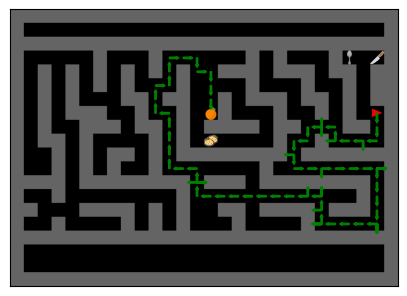

In [24]:
housemaze_analysis.render_path(user_df.episodes[0])

# Now compute metrics for each manipulation

In [27]:
def plot_users_sample(n=3, **kwargs):
    num_users = min(len(user_df['user_id'].unique()), n)
    fig, axes = plt.subplots(1, num_users, figsize=(3*num_users, 3), squeeze=False)
    axes = axes.flatten()
    
    # Iterate through unique models and plot each one
    users = list(user_df['user_id'].unique())[:num_users]
    for i, user in enumerate(users):
        episodes = user_df.filter(user_id=user, **kwargs).episodes
        housemaze_analysis.render_path(episodes[0], ax=axes[i])
        axes[i].set_title(user)
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

def plot_models_sample(**kwargs):
    num_models = len(model_df['algo'].unique())
    fig, axes = plt.subplots(1, num_models, figsize=(3*num_models, 3), squeeze=False)
    axes = axes.flatten()
    
    # Iterate through unique models and plot each one
    for i, model in enumerate(model_df['algo'].unique()):
        episodes = model_df.filter(algo=model, **kwargs).episodes
        housemaze_analysis.render_path(first(episodes[0]), ax=axes[i])
        axes[i].set_title(model)
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

---
## Manipulation 1: shortcut is introduced

Here, a short is introduced at evaluation time and we want to see if users follow the short-cut or if they use the old path

How will we compute for the user?
1. for each user, get the eval episode data
2. look for point on map which corresponds to "shortcut"
3. compute binary if the episode crossed through there

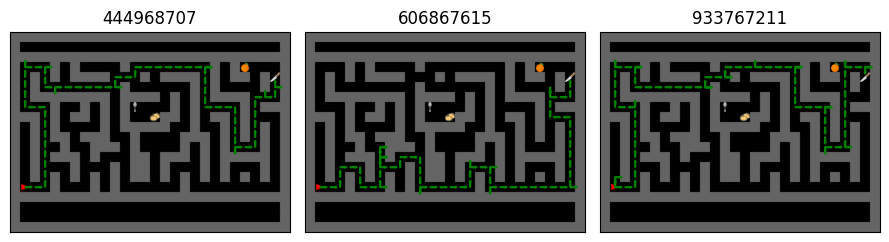

In [29]:
# plot_user_sample(manipulation=1, eval=True)
plot_users_sample(manipulation=1, eval=True)
plt.show()

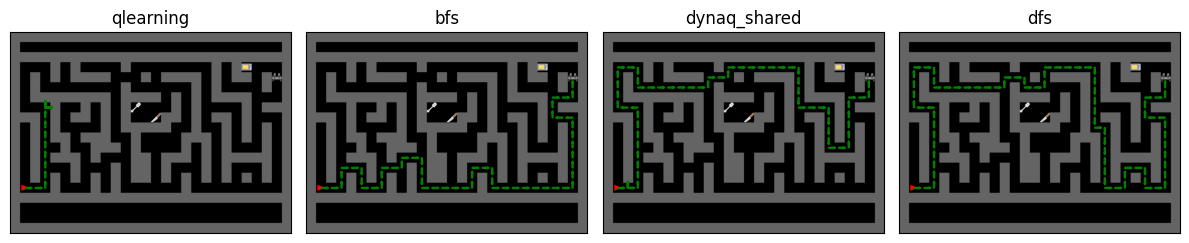

In [31]:
m1_model_settings = dict(maze_name='big_m1_maze3_shortcut', eval=True)
plot_models_sample(**m1_model_settings)


### time differences

In [40]:
from projects.humansf.dataframe import EpisodeDataFrame
def split_filter_fn(df):
    success = df.apply(housemaze_analysis.success)
    remove = True
    if len(success) == 0:
        return 0, remove
    nsuccess = sum(success)
    remove = nsuccess < 16
    return nsuccess, remove

def get_subset_on_conditions(
    df,
    split_filter_fn,
    split_filter_settings: dict,
    comp_settings: dict,
    comp_filter_fn=None,
    split_key: str = 'user_id'):

    keys = df[split_key].unique()
    dfs = []
    episodes = []
    for key in keys:
        filter_df = df.filter(**split_filter_settings, **{split_key: key})
        score, remove = split_filter_fn(filter_df)
        if remove:
            print(f"Skipping: {key} w/ {score:.2f}")
            continue
        sub = df.filter(**comp_settings, **{split_key: key})
        if comp_filter_fn:
            sub = sub.filter_row_with_episode(filter_fn=comp_filter_fn)
        dfs.append(sub._df)
        episodes.extend(sub.episodes)
    subset = (
        pl.concat(dfs, how="diagonal_relaxed")
        .with_row_count(name="row_number")
        .with_columns(
            pl.col("row_number").alias("index")
        )
        .drop("row_number")
    )
    return EpisodeDataFrame(subset, episodes)

manipulation = 1
subset = get_subset_on_conditions(
    df=user_df,
    split_filter_fn=split_filter_fn,
    comp_filter_fn=lambda e: housemaze_analysis.success(e) < 1,
    split_filter_settings=dict(manipulation=manipulation, eval=False),
    comp_settings=dict(manipulation=manipulation, eval=True),
)
subset.head(), len(subset)

/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_72764/2302492247.py:34: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  pl.concat(dfs, how="diagonal_relaxed")


(shape: (5, 12)
 ┌───────┬──────────┬──────────┬──────────────┬───┬──────┬────────────┬─────┬────────┐
 │ index ┆ stage    ┆ block    ┆ manipulation ┆ … ┆ room ┆ user_id    ┆ age ┆ sex    │
 │ ---   ┆ ---      ┆ ---      ┆ ---          ┆   ┆ ---  ┆ ---        ┆ --- ┆ ---    │
 │ u32   ┆ str      ┆ str      ┆ i64          ┆   ┆ i64  ┆ i64        ┆ i64 ┆ str    │
 ╞═══════╪══════════╪══════════╪══════════════╪═══╪══════╪════════════╪═════╪════════╡
 │ 0     ┆ shortcut ┆ shortcut ┆ 1            ┆ … ┆ 0    ┆ 444968707  ┆ 37  ┆ Male   │
 │ 1     ┆ shortcut ┆ shortcut ┆ 1            ┆ … ┆ 0    ┆ 606867615  ┆ 37  ┆ Female │
 │ 2     ┆ shortcut ┆ shortcut ┆ 1            ┆ … ┆ 0    ┆ 933767211  ┆ 35  ┆ Male   │
 │ 3     ┆ shortcut ┆ shortcut ┆ 1            ┆ … ┆ 0    ┆ 1067476058 ┆ 48  ┆ Female │
 │ 4     ┆ shortcut ┆ shortcut ┆ 1            ┆ … ┆ 0    ┆ 1415357222 ┆ 52  ┆ Female │
 └───────┴──────────┴──────────┴──────────────┴───┴──────┴────────────┴─────┴────────┘,
 13)

/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_72764/2302492247.py:34: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  pl.concat(dfs, how="diagonal_relaxed")
/Users/wilka/git/research/jaxneurorl/projects/humansf/housemaze_analysis.py:557: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/Users/wilka/git/research/jaxneurorl/projects/humansf/housemaze_analysis.py:557: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



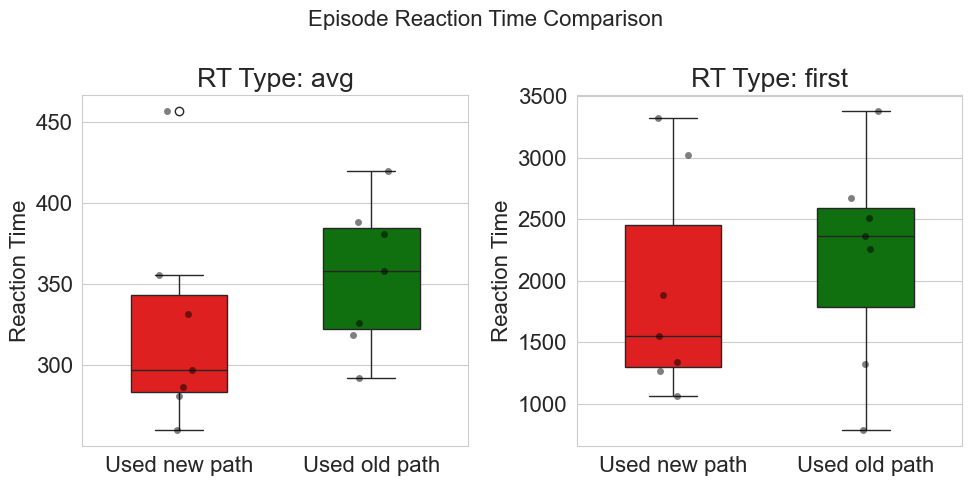

In [73]:
def split_filter_fn(df):
    success = df.apply(housemaze_analysis.success)
    remove = True
    if len(success) == 0:
        return 0, remove
    nsuccess = sum(success)
    remove = nsuccess < 16
    return nsuccess, remove
manipulation = 1

def sucess_or_not_terminate(e):
    terminated = e.timesteps.last().any()
    succeeded = housemaze_analysis.success(e) > 0
    keep = not terminated or succeeded
    return not keep
    
subset = get_subset_on_conditions(
    df=user_df,
    split_filter_fn=split_filter_fn,
    comp_filter_fn=lambda e: not housemaze_analysis.sucess_or_not_terminate(e),
    split_filter_settings=dict(manipulation=manipulation, eval=False),
    comp_settings=dict(manipulation=manipulation, eval=True),
)

user_settings = dict(manipulation=manipulation, eval=True)
old_path = functools.partial(housemaze_analysis.went_to_junction, junction=(2, 14))
old = [e for e in subset.filter(**user_settings).episodes if old_path(e)]
new = [e for e in subset.filter(**user_settings).episodes if not old_path(e)]

housemaze_analysis.plot_reaction_times(old, new, label2='Used new path', label1='Used old path')

---
## Manipulation 3: reusing longer of two paths which matches training path

Here there are 2 paths. do people take the short or long one?


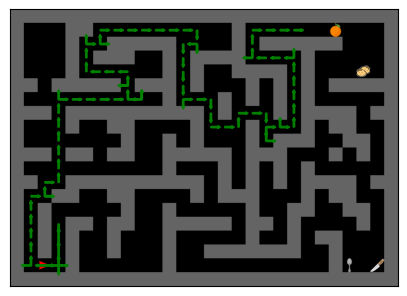

In [42]:
episodes = user_df.filter(manipulation=3, eval=True).episodes
housemaze_analysis.render_path(episodes[0])

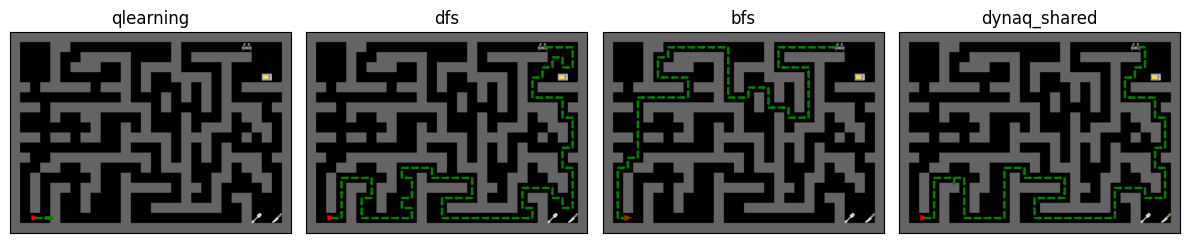

In [43]:
m3_model_settings = dict(maze_name='big_m3_maze1', eval=True)
plot_models_sample(**m3_model_settings)

/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_72764/2302492247.py:34: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  pl.concat(dfs, how="diagonal_relaxed")
/Users/wilka/git/research/jaxneurorl/projects/humansf/housemaze_analysis.py:557: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/Users/wilka/git/research/jaxneurorl/projects/humansf/housemaze_analysis.py:557: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



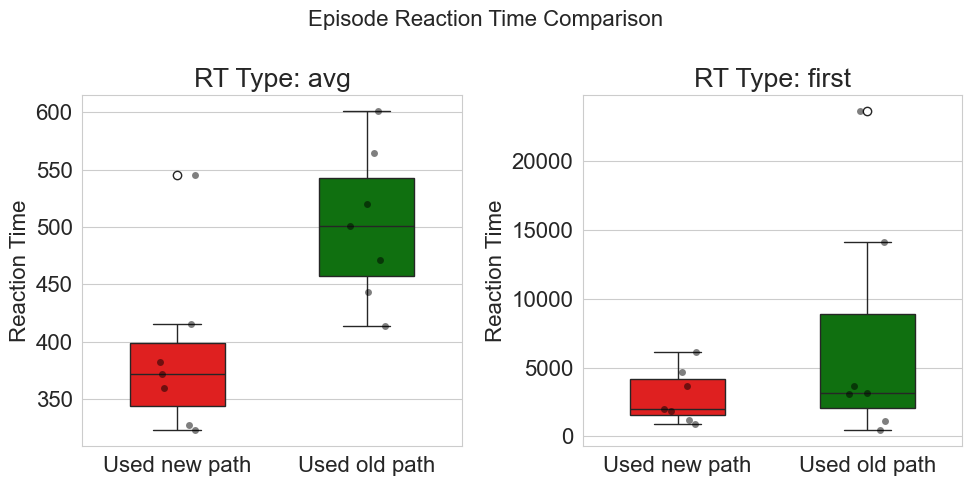

In [72]:
def split_filter_fn(df):
    success = df.apply(housemaze_analysis.success)
    remove = True
    if len(success) == 0:
        return 0, remove
    nsuccess = sum(success)
    remove = nsuccess < 16
    return nsuccess, remove

manipulation = 3
def sucess_or_not_terminate(e):
    terminated = e.timesteps.last().any()
    succeeded = housemaze_analysis.success(e) > 0
    keep = not terminated or succeeded
    return not keep
subset = get_subset_on_conditions(
    df=user_df,
    split_filter_fn=split_filter_fn,
    comp_filter_fn=lambda e: not housemaze_analysis.sucess_or_not_terminate(e),
    split_filter_settings=dict(manipulation=manipulation, eval=False),
    comp_settings=dict(manipulation=manipulation, eval=True),
)

user_settings = dict(manipulation=manipulation, eval=True)
episodes = subset.filter(**user_settings).episodes
old_path = functools.partial(housemaze_analysis.went_to_junction, junction=(14, 25))
new_path = functools.partial(housemaze_analysis.went_to_junction, junction=(14, 0))
old = [e for e in episodes if old_path(e)]
new = [e for e in episodes if new_path(e)]

housemaze_analysis.plot_reaction_times(old, new, label2='Used new path', label1='Used old path')

## Manipulations 1+3 together

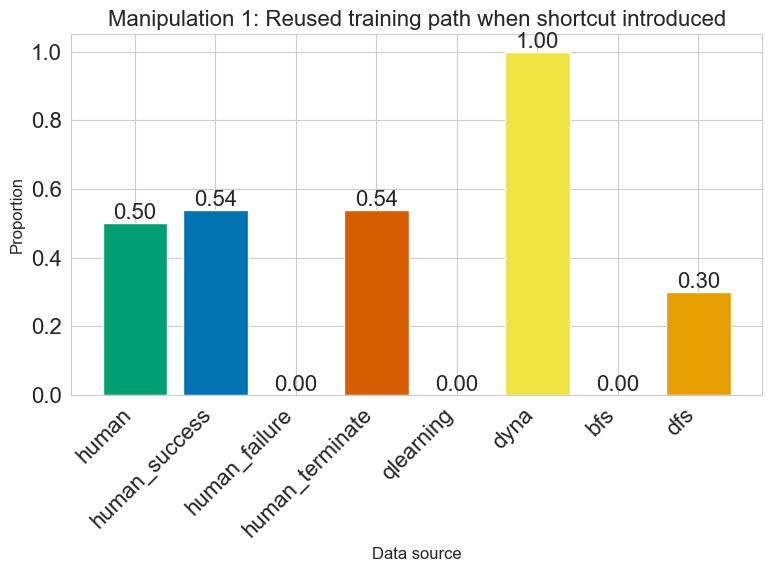

<Figure size 1200x600 with 0 Axes>

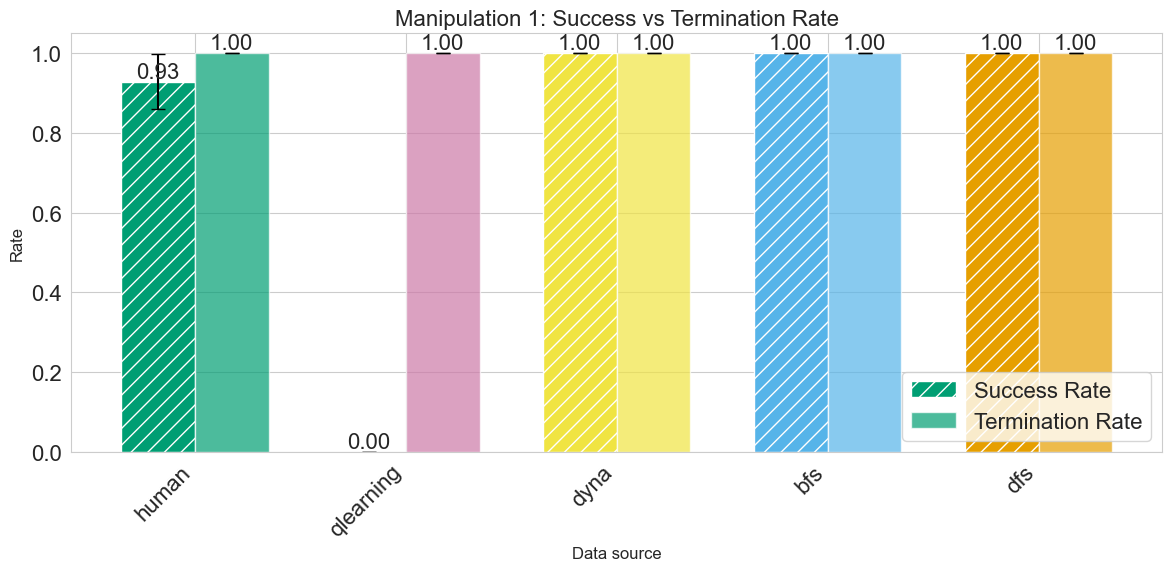

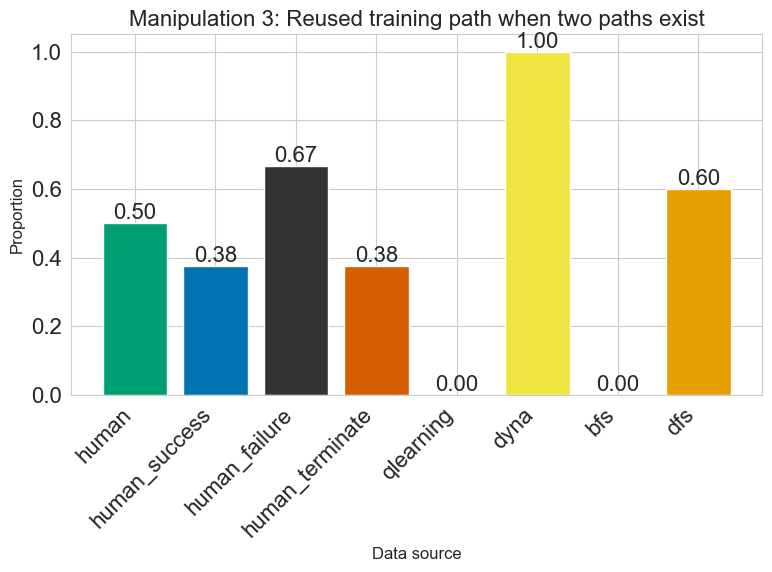

<Figure size 1200x600 with 0 Axes>

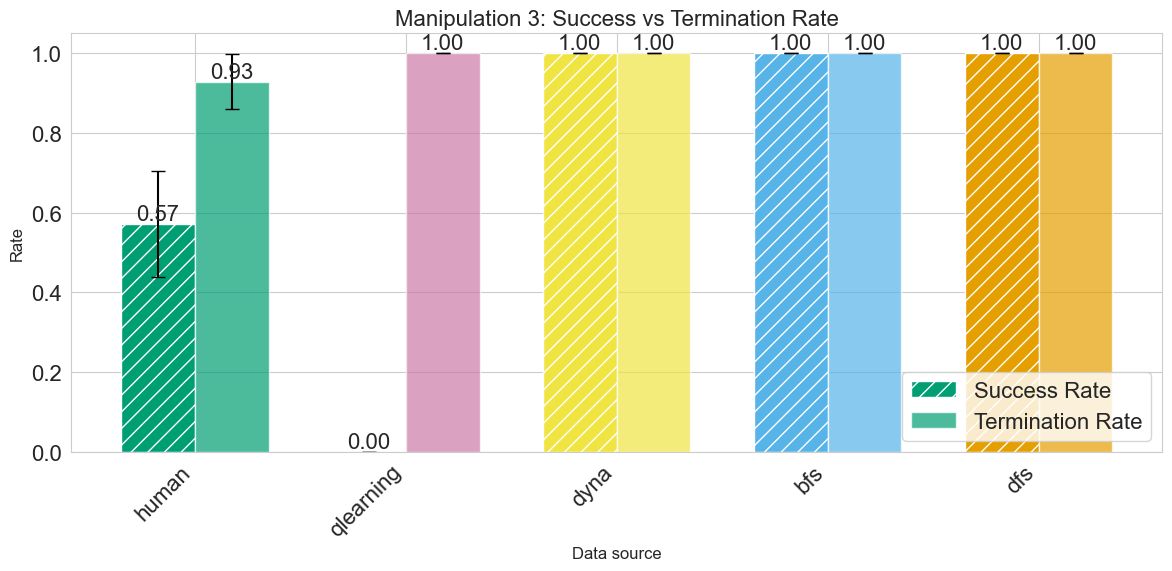

In [71]:
plt.rcParams.update({'font.size': 16})  # Increase the default font size

def went_to_junction(episode_data, junction = (0, 11)):
    positions = episode_data.positions
    if positions is None:
        positions = episode_data.timesteps.state.agent_pos
    match = np.array(junction) == positions
    match = (match).sum(-1) == 2 # both x and y matches
    return match.any().astype(jnp.float32)  # if any matched

def split_filter_fn(df):
    success = df.apply(housemaze_analysis.success)
    if len(success) == 0:
        return 0
    nsuccess = sum(success)
    return nsuccess < 16

########
# filters for epsisodes
########
filters = [
    lambda e: housemaze_analysis.success(e) < 1,
    lambda e: not e.timesteps.last().any(),
    None,
]
fnames = ['success', 'termination', 'none']
########
# change by manipulation
########
manipulations = [1, 3]
model_settings = [
    dict(maze_name='big_m1_maze3_shortcut', eval=True),
    dict(maze_name='big_m3_maze1', eval=True),
]
fns = [
    functools.partial(went_to_junction, junction=(2, 14)),
    functools.partial(went_to_junction, junction=(17, 17))
]
titles = [
    'Manipulation 1: Reused training path when shortcut introduced',
    'Manipulation 3: Reused training path when two paths exist'
]



for idx, (manipulation, model_setting, title, fn) in enumerate(zip(manipulations, model_settings, titles, fns)):
    model_setting = model_settings[idx]
    #####################
    # Reuse under conditions
    #####################
    model_fn = lambda e: jax.vmap(fn)(e)
    post_fn = lambda x: np.array(x)[0]
    def get_human_data(fn, filter_fn=None):
     return user_df.split_apply(
        fn=fn, comp_filter_fn=filter_fn,
        split_filter_fn=split_filter_fn,
        split_filter_settings=dict(manipulation=manipulation, eval=False),
        comp_settings=dict(manipulation=manipulation, eval=True),
    )
    data = dict(
        # vector of people
        human=get_human_data(fn=fn, filter_fn=None),
        human_success=get_human_data(fn=fn, filter_fn=lambda e: housemaze_analysis.success(e) < 1),
        human_failure=get_human_data(fn=fn, filter_fn=lambda e: housemaze_analysis.success(e)),
        human_terminate=get_human_data(fn=fn, filter_fn=lambda e: not housemaze_analysis.terminated(e)),
        # # vector of seeds
        qlearning=model_df.apply(fn=model_fn, post_fn=post_fn, algo="qlearning", **model_setting),
        dyna=model_df.apply(fn=model_fn, post_fn=post_fn, algo="dynaq_shared", **model_setting),
        bfs=model_df.apply(fn=model_fn, post_fn=post_fn,  algo='bfs', **model_setting),
        dfs=model_df.apply(fn=model_fn, post_fn=post_fn, algo='dfs', **model_setting),
    )
    # # pprint(data)
    # # break
    housemaze_analysis.bar_plot_results(
        data,
        figsize=(8,6),
        title=title,
        ylabel='Proportion')

    #####################
    # Success rate
    #####################
    fn = housemaze_analysis.success
    data_success = dict(
        # vector of people
        human=get_human_data(fn),
        # # vector of seeds
        qlearning=model_df.apply(fn=model_fn, algo="qlearning", **model_setting),
        dyna=model_df.apply(fn=model_fn, algo="dynaq_shared", **model_setting),
        bfs=model_df.apply(fn=model_fn, algo='bfs', **model_setting),
        dfs=model_df.apply(fn=model_fn, algo='dfs', **model_setting),
    )

    #####################
    # Termination rate
    #####################
    fn = lambda e: e.timesteps.last().any()
    data_termination = dict(
        # vector of people
        human=get_human_data(fn),
        # # vector of seeds
        qlearning=model_df.apply(fn=model_fn, algo="qlearning", **model_setting),
        dyna=model_df.apply(fn=model_fn, algo="dynaq_shared", **model_setting),
        bfs=model_df.apply(fn=model_fn, algo='bfs', **model_setting),
        dfs=model_df.apply(fn=model_fn, algo='dfs', **model_setting),
    )
    housemaze_analysis.success_termination_results(
        data_success,
        data_termination,
        title=f'Manipulation {manipulation}: Success vs Termination Rate',
        ylabel='Rate'
    )


## Manipulation 2: faster when on-path but further than off-path but closer
In both tests, a shortcut is introduced. In the first, the agent is tested on the same path it trained on. In the second, the agent is tested on a different path.reusing longer of two paths which matches training path

Here there are 2 paths. do people take the short or long one?


what do I want to do?
1. I want to get the user data for each participant for the episode
2. I want to get a vector of the reaction times. for now, just plot that as a histogram. 4 histograms alone may be informative....

new location, on-path
482
1581
756
254


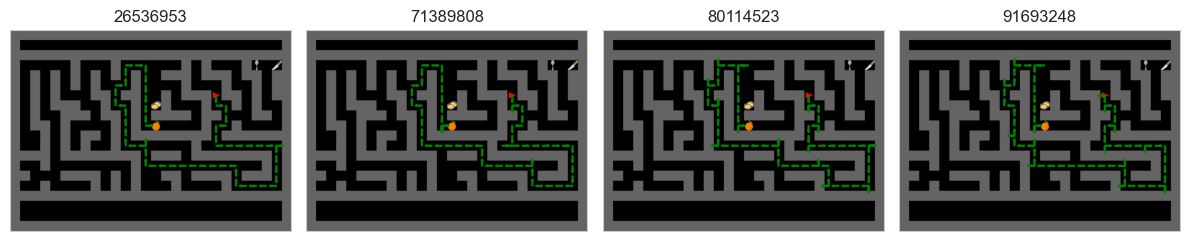

new location, off-path
483
1582
757
255


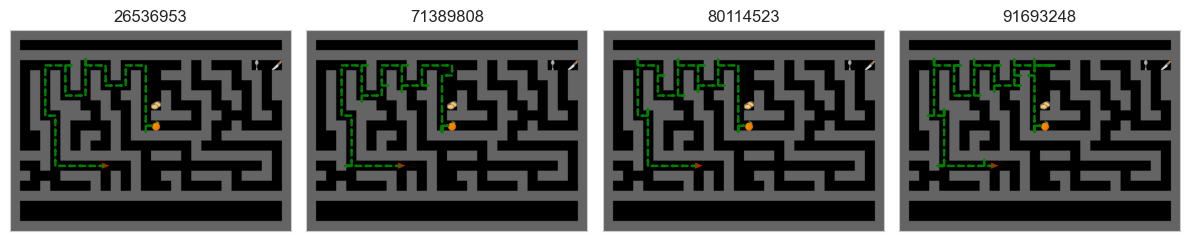

In [116]:
sub_df = user_df.filter(manipulation=2, eval=True)
for stage in sub_df['stage'].unique():
    print(stage)
    plot_users_sample(dict(manipulation=2, eval=True, stage=stage))
    plt.show()

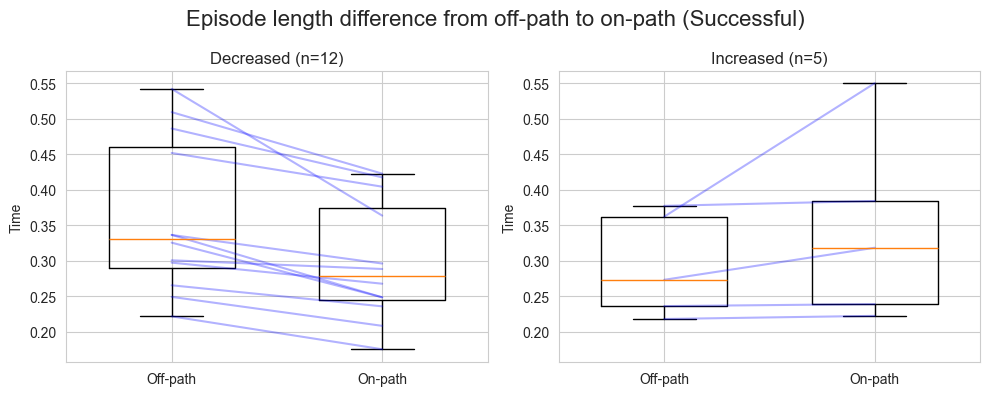

In [332]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_visualize_time_difference(t1, t2, title="Comparison of t1 and t2 with Individual Changes"):
    """
    Analyzes the time difference between two paired time series and creates two side-by-side visualizations:
    one for positive differences and one for negative differences.
    
    Args:
    t1 (array-like): First time series
    t2 (array-like): Second time series (paired with t1)
    title (str): Main title for the plot
    
    Returns:
    None
    """
    
    t1 = np.array(t1)
    t2 = np.array(t2)
    
    # Calculate the differences
    differences = t1 - t2
    
    # Split the data into positive and negative differences
    positive_mask = differences > 0
    negative_mask = differences < 0
    
    t1_pos, t2_pos = t1[positive_mask], t2[positive_mask]
    t1_neg, t2_neg = t1[negative_mask], t2[negative_mask]
    
    # Create the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=16)
    
    # Function to create a single plot
    def create_subplot(ax, t1, t2, title):
        bp = ax.boxplot([t1, t2], positions=[1, 2], widths=0.6)
        for i in range(len(t1)):
            ax.plot([1, 2], [t1[i], t2[i]], 'b-', alpha=0.3)
        ax.set_xlim(0.5, 2.5)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Off-path', 'On-path'])
        ax.set_ylabel('Time')
        ax.set_title(title)
    
    # Create positive differences plot
    create_subplot(ax1, t1_pos, t2_pos, f"Decreased (n={len(t1_pos)})")
    
    # Create negative differences plot
    create_subplot(ax2, t1_neg, t2_neg, f"Increased (n={len(t1_neg)})")

    # Set the same y-axis limits for both subplots
    y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
    y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()

def filter_pairs(list1, list2, filter_fn):
    """
    Filter out pairs from both lists if the filter_fn returns True for either element.
    
    Args:
    list1, list2: Lists of equal length to be filtered
    filter_fn: A function that takes an element and returns True if it should be filtered out
    
    Returns:
    Tuple of two lists with filtered pairs removed
    """
    filtered1, filtered2 = [], []
    for e1, e2 in zip(list1, list2):
        if not (filter_fn(e1) or filter_fn(e2)):
            filtered1.append(e1)
            filtered2.append(e2)
    return filtered1, filtered2

def filter_none_pairs(list1, list2):
    """
    Filter out pairs where either value is None from both lists simultaneously.
    
    Args:
    list1, list2: Lists of equal length to be filtered
    
    Returns:
    Tuple of two lists with None pairs removed
    """
    filtered1, filtered2 = [], []
    for v1, v2 in zip(list1, list2):
        if v1 is not None and v2 is not None:
            filtered1.append(v1)
            filtered2.append(v2)
    return filtered1, filtered2

def rt_fn(e):
    rts = e.reaction_times[:-1]
    if len(rts) == 0:
        return None
    # return rts[0] + rts[1:].mean()/1000
    return rts.mean()/1000


# Example usage:
user_settings = dict(manipulation=2, eval=True)
on_idxs = get_user_samples(**user_settings, stage="new location, on-path")
on_data = [user_data[idx] for idx in on_idxs]

off_idxs = get_user_samples(**user_settings, stage="new location, off-path")
off_data = [user_data[idx] for idx in off_idxs]


# filter_fn = lambda e: housemaze_analysis.success(e) < 1
# off_data, on_data = filter_pairs(off_data, on_data, filter_fn=filter_fn)


# off_rts = [rt_fn(e) for e in off_data]
# on_rts = [rt_fn(e) for e in on_data]

# off_rts, on_rts = filter_none_pairs(off_rts, on_rts)

# analyze_and_visualize_time_difference(off_rts, on_rts, title="Episode length difference from off-path to on-path (Successful)")


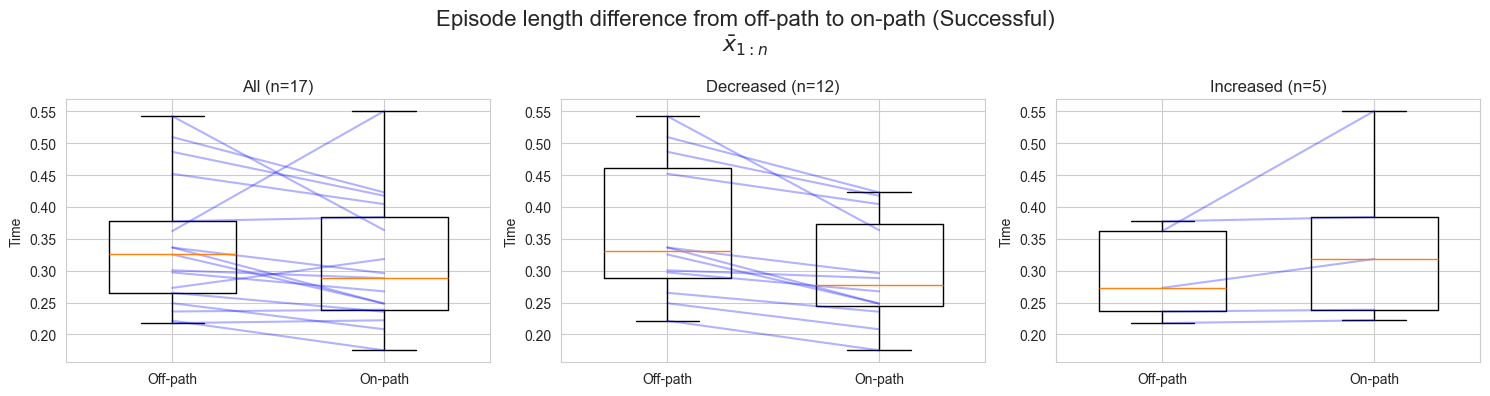

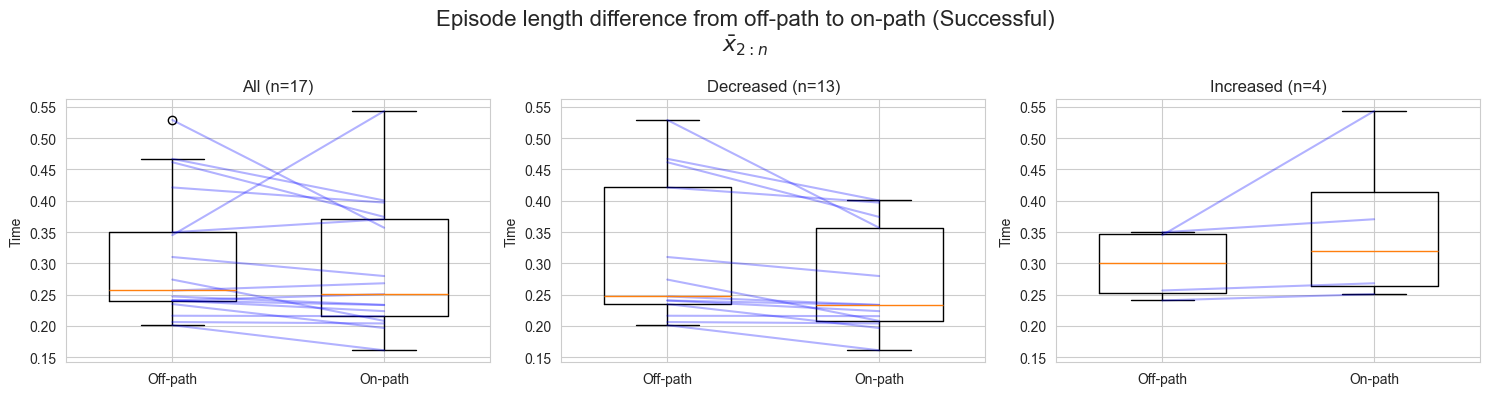

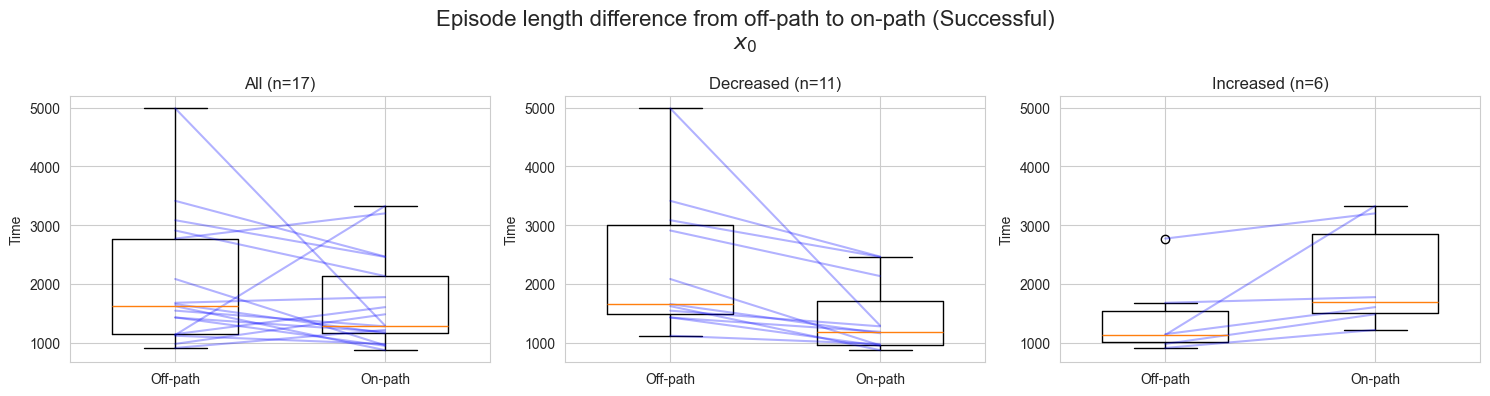

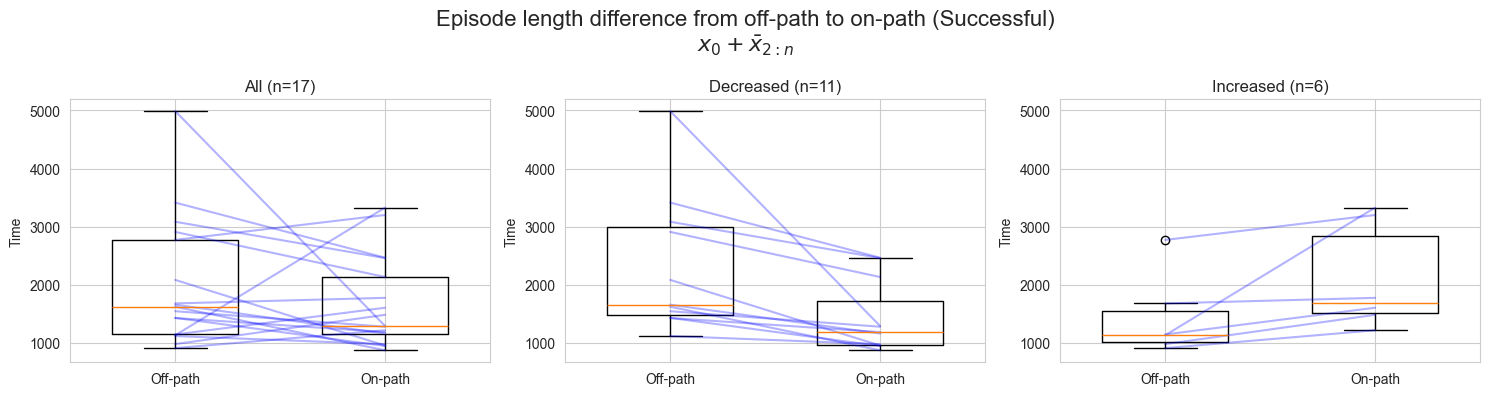

In [349]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_visualize_time_difference(off_data, on_data, rt_fn, filter_fn=None, title="Comparison of Off-path and On-path Times"):
    """
    Analyzes the time difference between two paired time series and creates three side-by-side visualizations:
    one for all differences, one for positive differences, and one for negative differences.
    
    Args:
    off_data (list): List of off-path data
    on_data (list): List of on-path data (paired with off_data)
    rt_fn (function): Function to calculate reaction time for each data point
    title (str): Main title for the plot
    
    Returns:
    None
    """
    
    def filter_pairs(list1, list2, filter_fn):
        """
        Filter out pairs from both lists if the filter_fn returns True for either element.
        
        Args:
        list1, list2: Lists of equal length to be filtered
        filter_fn: A function that takes an element and returns True if it should be filtered out
        
        Returns:
        Tuple of two lists with filtered pairs removed
        """
        filtered1, filtered2 = [], []
        for e1, e2 in zip(list1, list2):
            if not (filter_fn(e1) or filter_fn(e2)):
                filtered1.append(e1)
                filtered2.append(e2)
        return filtered1, filtered2

    off_data, on_data = filter_pairs(off_data, on_data, filter_fn=filter_fn)

    def filter_none_pairs(list1, list2):
        filtered1, filtered2 = [], []
        for v1, v2 in zip(list1, list2):
            if v1 is not None and v2 is not None:
                filtered1.append(v1)
                filtered2.append(v2)
        return filtered1, filtered2
    
    # Calculate reaction times
    off_rts = [rt_fn(e) for e in off_data]
    on_rts = [rt_fn(e) for e in on_data]
    
    # Filter out None values
    off_rts, on_rts = filter_none_pairs(off_rts, on_rts)
    
    # Convert to numpy arrays
    t1 = np.array(off_rts)
    t2 = np.array(on_rts)
    
    # Calculate the differences
    differences = t1 - t2
    
    # Split the data into positive and negative differences
    positive_mask = differences > 0
    negative_mask = differences < 0
    
    t1_pos, t2_pos = t1[positive_mask], t2[positive_mask]
    t1_neg, t2_neg = t1[negative_mask], t2[negative_mask]
    
    # Create the figure with three subplots
    fig, (ax_all, ax_pos, ax_neg) = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(title, fontsize=16)
    
    # Function to create a single plot
    def create_subplot(ax, t1, t2, title):
        bp = ax.boxplot([t1, t2], positions=[1, 2], widths=0.6)
        for i in range(len(t1)):
            ax.plot([1, 2], [t1[i], t2[i]], 'b-', alpha=0.3)
        ax.set_xlim(0.5, 2.5)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Off-path', 'On-path'])
        ax.set_ylabel('Time')
        ax.set_title(title)
    
    # Create all differences plot
    create_subplot(ax_all, t1, t2, f"All (n={len(t1)})")
    
    # Create positive differences plot
    create_subplot(ax_pos, t1_pos, t2_pos, f"Decreased (n={len(t1_pos)})")
    
    # Create negative differences plot
    create_subplot(ax_neg, t1_neg, t2_neg, f"Increased (n={len(t1_neg)})")
    
    # Set the same y-axis limits for all subplots
    y_min = min(ax_all.get_ylim()[0], ax_pos.get_ylim()[0], ax_neg.get_ylim()[0])
    y_max = max(ax_all.get_ylim()[1], ax_pos.get_ylim()[1], ax_neg.get_ylim()[1])
    ax_all.set_ylim(y_min, y_max)
    ax_pos.set_ylim(y_min, y_max)
    ax_neg.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()

def rt_fn(e, op: int = 0):
    rts = e.reaction_times[:-1]
    if len(rts) == 0:
        return None
    if op == 0:
        return rts.mean()/1000
    elif op == 1:
        return rts[1:].mean()/1000
    elif op == 2:
        return rts[0].mean()
    elif op == 3:
        return rts[0] + rts[1:].mean()/1000

rt_fns = [
    functools.partial(rt_fn, op=0),
    functools.partial(rt_fn, op=1),
    functools.partial(rt_fn, op=2),
    functools.partial(rt_fn, op=3),
]
rt_names = [
    '$\sum^n_{i=1}$',
    '$\sum^n_{i=2}$',
    '$x_0$',
    ' $x_0 + \\frac{1}{n-1} \sum^n_{i=1} x_i$',
]
rt_names = [
    '$\\bar{x}_{1:n}$',
    '$\\bar{x}_{2:n}$',
    '$x_0$',
    '$x_0 + \\bar{x}_{2:n}$',
    # '$\\frac{1}{n} \sum^n_{i=1} x_i$',
    # '$\\frac{1}{n-1} \sum^n_{i=2} x_i$',
    # '$x_0$',
    # '$x_0 + \\frac{1}{n-1} \sum^n_{i=1} x_i$',
]
# Example usage:

for rt_fn, rt_name in zip(rt_fns, rt_names):
    analyze_and_visualize_time_difference(
        off_data, on_data, rt_fn=rt_fn, 
        filter_fn = lambda e: housemaze_analysis.success(e) < 1,
        title=f"Episode length difference from off-path to on-path (Successful)\n{rt_name}")

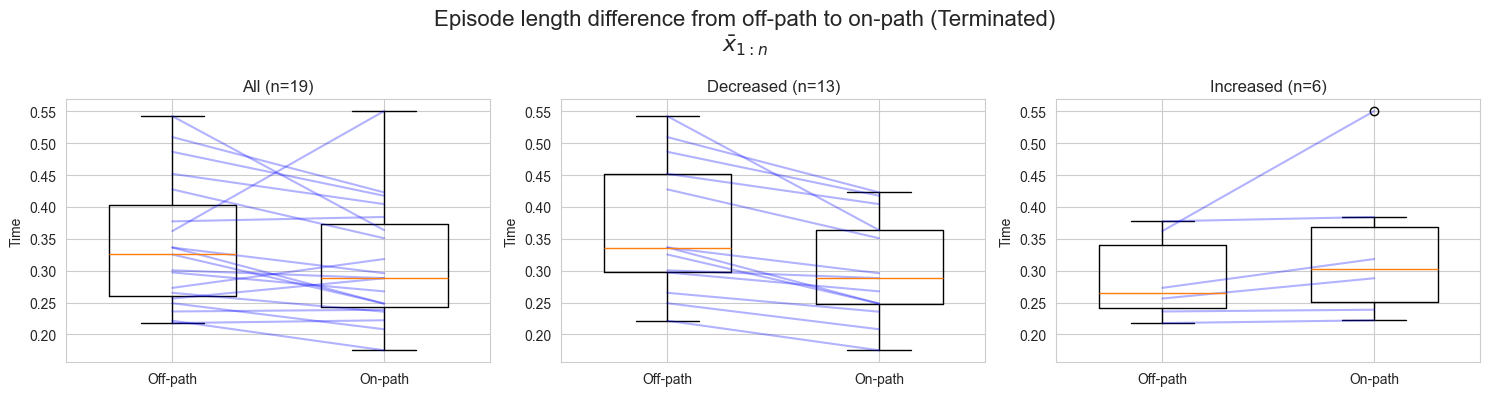

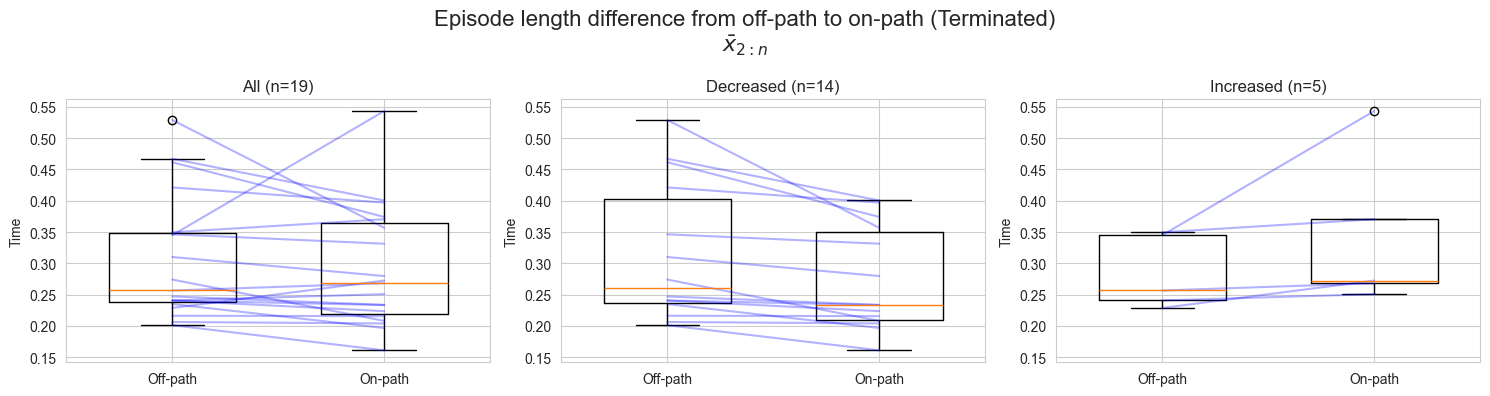

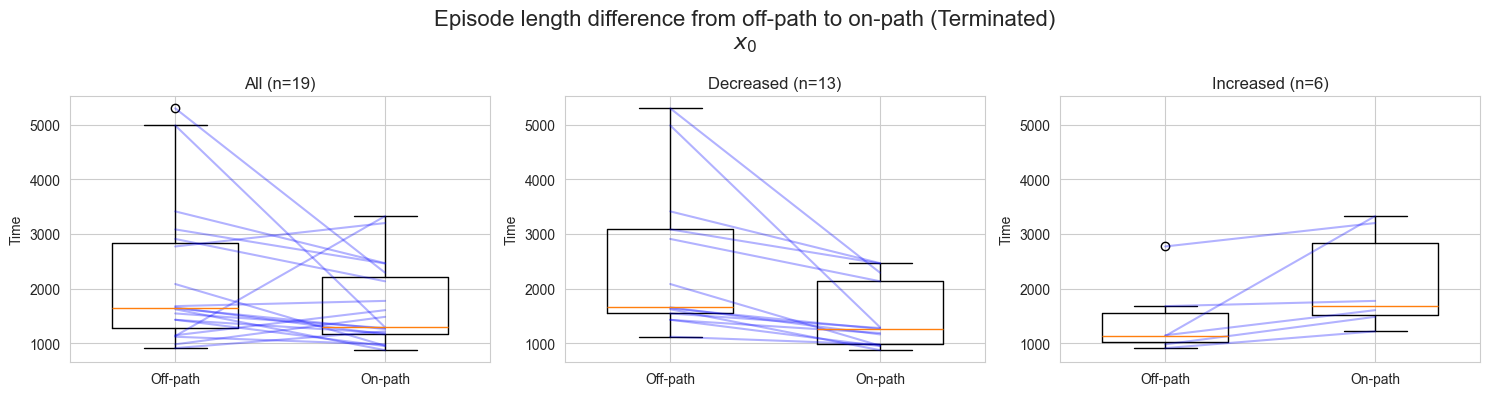

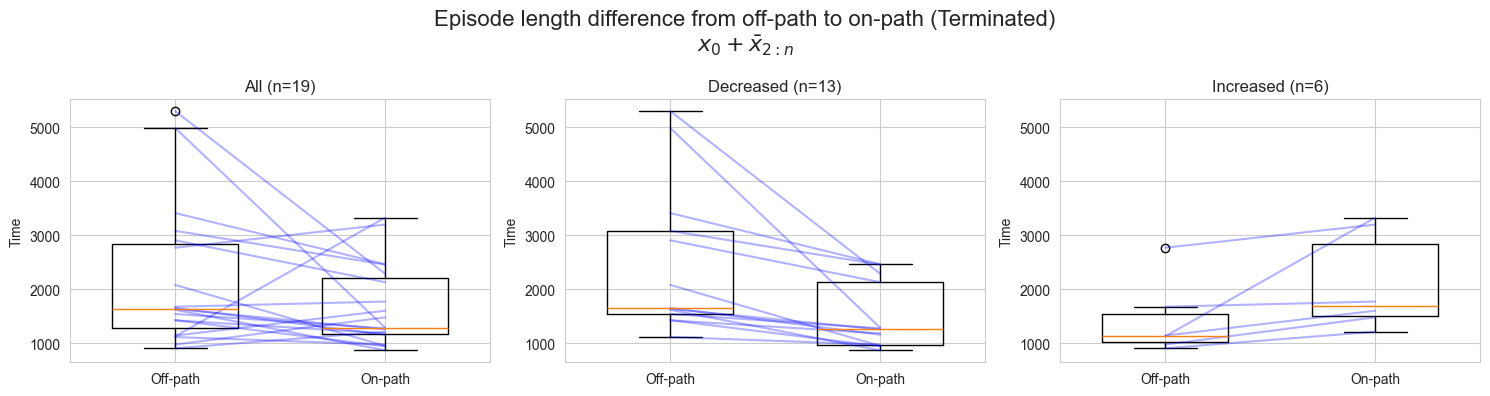

In [350]:
# user_settings = dict(manipulation=2, eval=True)
# on_idxs = get_user_samples(**user_settings, stage="new location, on-path")
# on_data = [user_data[idx] for idx in on_idxs]

# off_idxs = get_user_samples(**user_settings, stage="new location, off-path")
# off_data = [user_data[idx] for idx in off_idxs]

filter_fn = lambda e: housemaze_analysis.terminated(e) < 1
for rt_fn, rt_name in zip(rt_fns, rt_names):
    analyze_and_visualize_time_difference(
        off_data, on_data, rt_fn=rt_fn, 
        filter_fn=filter_fn,
        title=f"Episode length difference from off-path to on-path (Terminated)\n{rt_name}")
# off_data, on_data = filter_pairs(off_data, on_data, filter_fn=filter_fn)

# off_rts = [rt_fn(e) for e in off_data]
# on_rts = [rt_fn(e) for e in on_data]

# off_rts, on_rts = filter_none_pairs(off_rts, on_rts)

# analyze_and_visualize_time_difference(off_rts, on_rts, title="Episode length difference from off-path to on-path (Terminated)")


Stage: new location, off-path


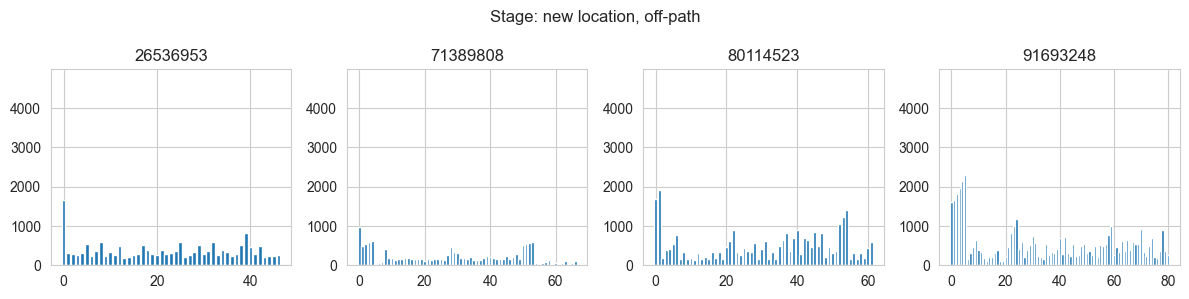

Stage: new location, on-path


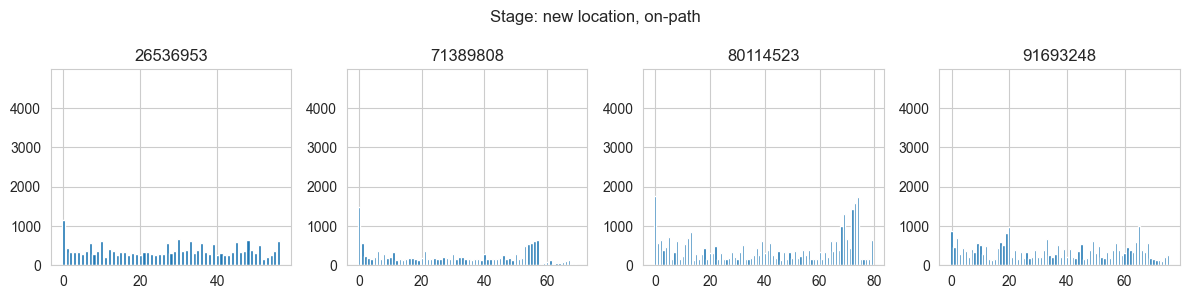

In [117]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reaction_hists(user_df, user_data, user_settings, y_max, use_final=False):
    num_users = min(len(user_df['user_id'].unique()), 4)
    fig, axes = plt.subplots(1, num_users, figsize=(3*num_users, 3), squeeze=False)
    axes = axes.flatten()
    
    users = list(user_df['user_id'].unique())[:num_users]
    
    for i, user in enumerate(users):
        eval_df = user_df.filter(user_id=user, **user_settings)
        idxs = np.array(eval_df['index'])-1
        assert len(idxs) == 1, f'{len(idxs)} options?'
        episode_data = user_data[idxs[0]]
        if use_final: reaction_times = episode_data.reaction_times
        else: reaction_times = episode_data.reaction_times[:-1]

        
        axes[i].bar(np.arange(len(reaction_times)), reaction_times)
        axes[i].set_title(user)
        axes[i].set_ylim(0, y_max)  # Set the same y-axis limit for all plots
    
    plt.suptitle(f"Stage: {user_settings['stage']}")
    plt.tight_layout()
    plt.show()

def plot_all_stages(user_df, user_data, use_final=False, filter_fn=None, **kwargs):
    sub_df = user_df.filter(**kwargs)
    stages = ["new location, off-path", "new location, on-path"]
    
    # First, find the global maximum reaction time across all stages
    all_reaction_times = []
    for stage in stages:
        stage_df = sub_df.filter(stage=stage)
        for user in stage_df['user_id'].unique():
            eval_df = stage_df.filter(user_id=user)
            idxs = np.array(eval_df['index'])-1
            episode_data = user_data[idxs[0]]
            if filter_fn is not None:
                if filter_fn(episode_data): continue
            if use_final: rts = episode_data.reaction_times
            else: rts = episode_data.reaction_times[:-1]
            all_reaction_times.extend(rts)
    
    global_y_max = max(all_reaction_times)
    
    # Now plot for each stage
    for stage in stages:
        print(f"Stage: {stage}")
        plot_reaction_hists(user_df, user_data, 
                            use_final=use_final,
                            user_settings=dict(**kwargs, stage=stage),
                            y_max=global_y_max)

# Usage
filter_fn = lambda e: housemaze_analysis.success(e) < 1
plot_all_stages(user_df, user_data, filter_fn=filter_fn, use_final=False, manipulation=2, eval=True)

Went positive?: 11 / 17


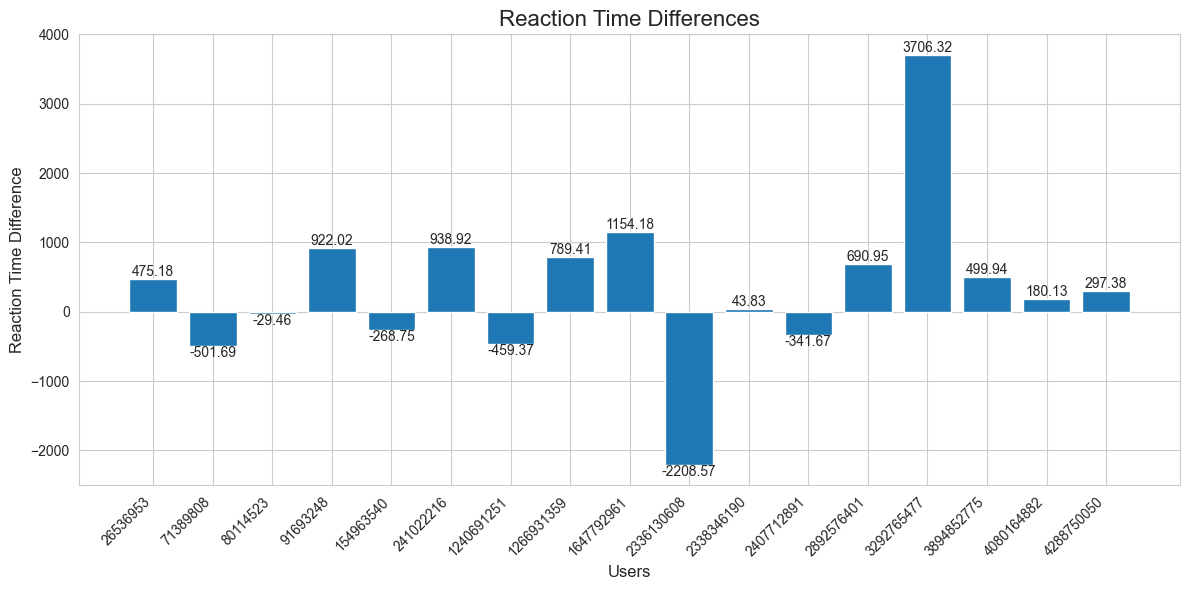

In [168]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reaction_time_differences(user_df, user_data, use_final=False, filter_fn=None, rt_fn=np.sum, **kwargs):
    sub_df = user_df.filter(**kwargs)
    stages = ["new location, off-path", "new location, on-path"]
    
    assert len(stages) == 2, "This function assumes there are exactly 2 stages"
    
    # Dictionary to store reaction times for each user in each stage
    user_reaction_times = {}
    
    for stage in stages:
        stage_df = sub_df.filter(stage=stage)
        for user in stage_df['user_id'].unique():
            if user not in user_reaction_times:
                user_reaction_times[user] = {}
            
            eval_df = stage_df.filter(user_id=user)
            idxs = np.array(eval_df['index']) - 1
            episode_data = user_data[idxs[0]]
            
            if filter_fn is not None:
                if filter_fn(episode_data):
                    continue
            
            if use_final:
                rts = episode_data.reaction_times
            else:
                rts = episode_data.reaction_times[:-1]
            
            user_reaction_times[user][stage] = rt_fn(rts)
    # pprint(user_reaction_times)
    # Calculate differences and prepare data for plotting
    users = []
    differences = []
    
    for user, stages_data in user_reaction_times.items():
        if len(stages_data) == 2:  # Ensure user has data for both stages
            users.append(user)
            diff = stages_data[stages[0]] - stages_data[stages[1]]
            differences.append(diff)
        # else:
        #     print("failed?")
    print("Went positive?:", (np.array(differences)>0).sum(), "/", len(differences))
    # Create the bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar([str(u) for u in users], differences)
    
    # Customize the plot
    plt.title(f"Reaction Time Differences", fontsize=16)
    plt.xlabel("Users", fontsize=12)
    plt.ylabel("Reaction Time Difference", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add a horizontal line at y=0
    # plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom' if height > 0 else 'top')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()



# Usage
filter_fn = lambda e: housemaze_analysis.success(e) < 1

def rt_fn(rts):
    first = rts[0]
    return first + rts[1:].mean()
plot_reaction_time_differences(user_df, user_data, filter_fn=filter_fn, rt_fn=rt_fn, use_final=False, manipulation=2, eval=True)

Went positive?: 11 / 17


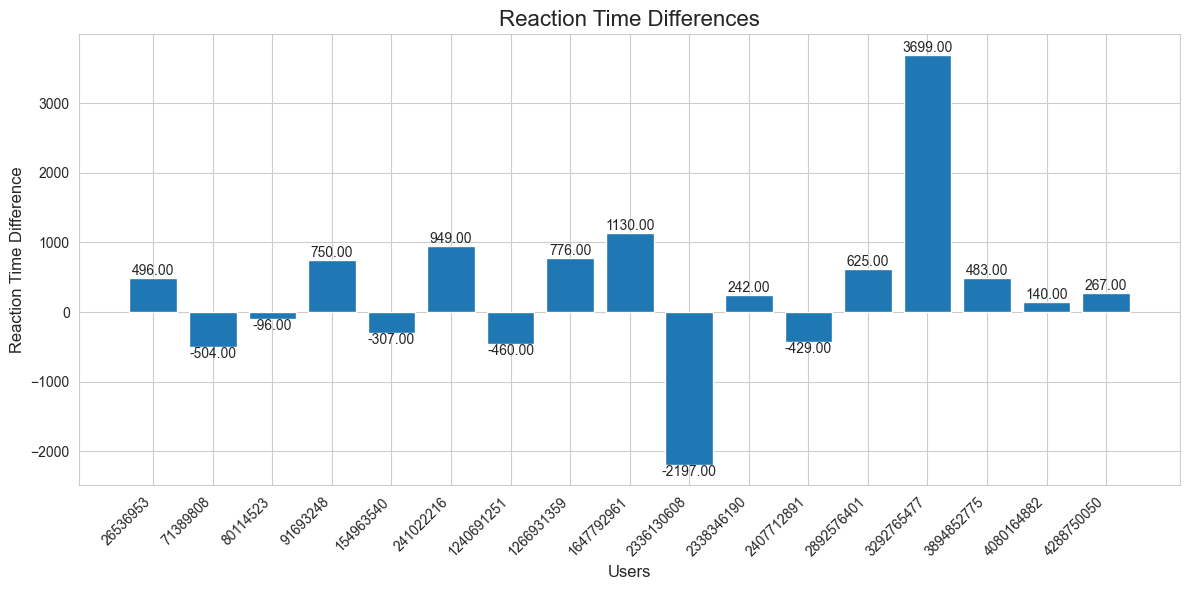

In [119]:
def rt_fn(rts):
    return rts[0]
plot_reaction_time_differences(user_df, user_data, filter_fn=filter_fn, rt_fn=rt_fn, use_final=False, manipulation=2, eval=True)

Went positive?: 13 / 17


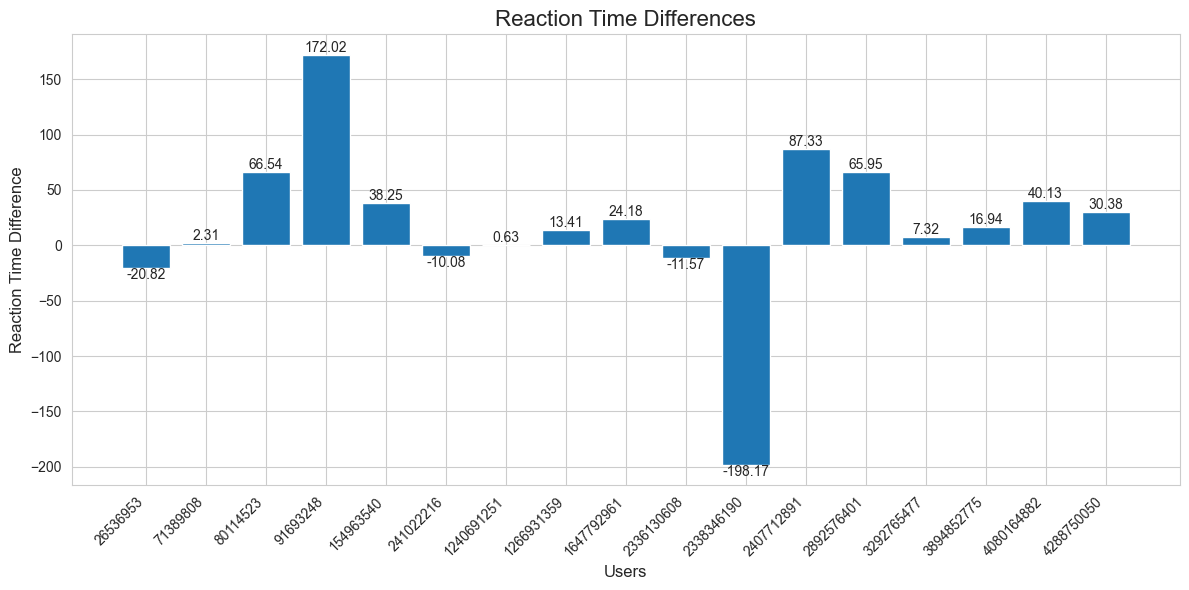

In [120]:
def rt_fn(rts):
    return rts[1:].mean()
plot_reaction_time_differences(user_df, user_data, filter_fn=filter_fn, rt_fn=rt_fn, use_final=False, manipulation=2, eval=True)

# Custom Analsysis

## success rates and episode times

In [395]:
idxs = get_user_samples(user_id=1852671773, eval=False, manipulation=3)
episodes = [user_data[idx] for idx in idxs]
len(episodes)

0

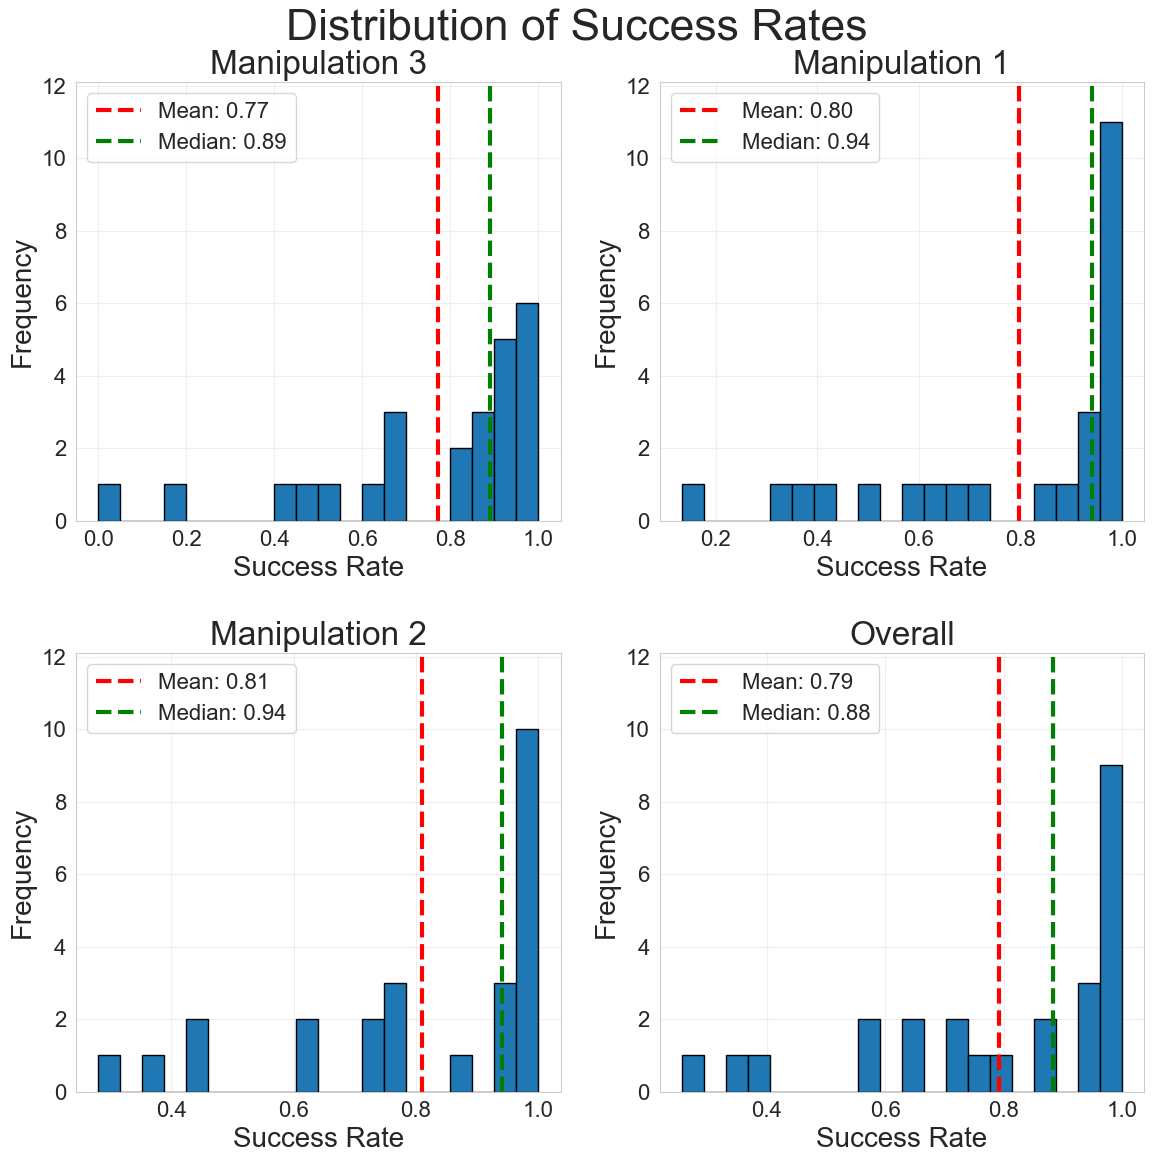

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_distribution(user_df, **kwargs):
    plt.rcParams.update({'font.size': 22})  # Increase the default font size
    manipulations = kwargs.pop('manipulations', [1, 2, 3])
    xlabel_size = kwargs.pop('xlabel_size', 20)
    ylabel_size = kwargs.pop('ylabel_size', 20)
    legend_size = kwargs.pop('legend_size', 16)
    title_size = kwargs.pop('title_size', 24)
    main_title_size = kwargs.pop('main_title_size', 32)
    
    user_ids = user_df['user_id'].unique()
    # Dictionary to store success rates for each user and manipulation
    user_success_rates = defaultdict(lambda: defaultdict(list))
    for manipulation in manipulations:
        for user_id in user_ids:
            # List[scalar]
            srs = user_df.apply(fn=housemaze_analysis.success, user_id=user_id, manipulation=manipulation, **kwargs)
            if len(srs):
                # Store success rate for this user and manipulation
                user_success_rates[manipulation][user_id] = np.mean(srs)
            else:
                user_success_rates[manipulation][user_id] = 0
    
    # Calculate overall average success rate for each user
    overall_success_rates = [np.mean([user_success_rates[m][user_id] for m in manipulations]) for user_id in user_ids]
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Distribution of Success Rates', fontsize=main_title_size)
    
    # Function to plot histogram and add statistics
    def plot_histogram(ax, data, title):
        n, bins, patches = ax.hist(data, bins=20, edgecolor='black')
        ax.set_title(title, fontsize=title_size)
        ax.set_xlabel('Success Rate', fontsize=xlabel_size)
        ax.set_ylabel('Frequency', fontsize=ylabel_size)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.grid(True, alpha=0.3)
        
        mean_rate = np.mean(data)
        median_rate = np.median(data)
        ax.axvline(mean_rate, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {mean_rate:.2f}')
        ax.axvline(median_rate, color='green', linestyle='dashed', linewidth=3, label=f'Median: {median_rate:.2f}')
        ax.legend(fontsize=legend_size)
        
        return mean_rate, median_rate, max(n)
    
    # First pass to determine the maximum frequency
    max_frequency = 0
    for i, manipulation in enumerate(manipulations):
        data = list(user_success_rates[manipulation].values())
        _, _, freq = plot_histogram(axs[i//2, i%2], data, f'Manipulation {manipulation}')
        max_frequency = max(max_frequency, freq)
    
    # Include overall data in max frequency calculation
    _, _, freq = plot_histogram(axs[1, 1], overall_success_rates, 'Overall')
    max_frequency = max(max_frequency, freq)
    
    # Second pass to plot with consistent y-axis and add text
    for i, manipulation in enumerate(manipulations):
        data = list(user_success_rates[manipulation].values())
        row, col = divmod(i, 2)
        axs[row, col].clear()  # Clear the previous plot
        mean, median, _ = plot_histogram(axs[row, col], data, f'Manipulation {manipulation}')
        axs[row, col].set_ylim(0, max_frequency * 1.1)  # Set y-axis limit with 10% padding
    
    # Plot overall histogram with consistent y-axis
    axs[1, 1].clear()  # Clear the previous plot
    mean, median, _ = plot_histogram(axs[1, 1], overall_success_rates, 'Overall')
    axs[1, 1].set_ylim(0, max_frequency * 1.1)  # Set y-axis limit with 10% padding
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust to make room for suptitle
    plt.show()
# Example usage:
# plot_distribution(user_df, eval=True)
plot_distribution(user_df, eval=False, manipulations=[3, 1, 2])

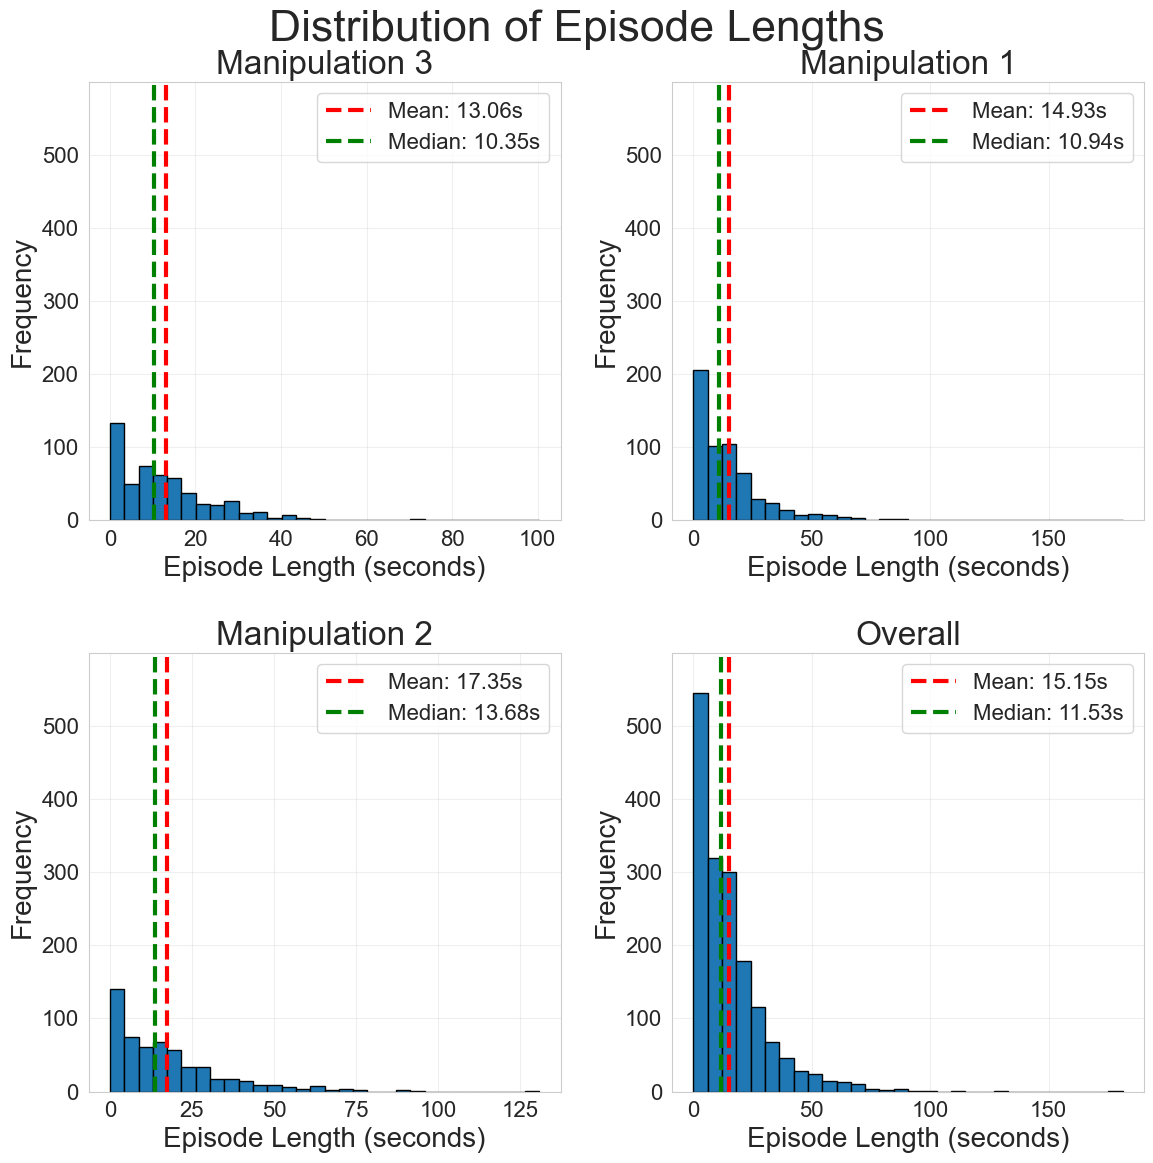

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_episode_length_distribution(user_df, **kwargs):
    plt.rcParams.update({'font.size': 22})  # Increase the default font size
    manipulations = kwargs.pop('manipulations', [1, 2, 3])
    xlabel_size = kwargs.pop('xlabel_size', 20)
    ylabel_size = kwargs.pop('ylabel_size', 20)
    legend_size = kwargs.pop('legend_size', 16)
    title_size = kwargs.pop('title_size', 24)
    main_title_size = kwargs.pop('main_title_size', 32)
    
    user_ids = user_df['user_id'].unique()
    # Dictionary to store episode lengths for each user and manipulation
    user_episode_lengths = defaultdict(lambda: defaultdict(list))
    
    for manipulation in manipulations:
        for user_id in user_ids:
            # Filter the DataFrame for the current user and manipulation
            user_data = user_df.filter(user_id=user_id, manipulation=manipulation, **kwargs)
            for episode in user_data.episodes:
                # Calculate episode length as the sum of reaction times
                episode_length = episode.reaction_times[::-1].sum()/1000
                user_episode_lengths[manipulation][user_id].append(episode_length)
    
    # Calculate overall episode lengths across all manipulations
    overall_episode_lengths = [length for m in manipulations for user_lengths in user_episode_lengths[m].values() for length in user_lengths]
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Distribution of Episode Lengths', fontsize=main_title_size)
    
    # Function to plot histogram and add statistics
    def plot_histogram(ax, data, title):
        n, bins, patches = ax.hist(data, bins=30, edgecolor='black')
        ax.set_title(title, fontsize=title_size)
        ax.set_xlabel('Episode Length (seconds)', fontsize=xlabel_size)
        ax.set_ylabel('Frequency', fontsize=ylabel_size)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.grid(True, alpha=0.3)
        
        mean_length = np.mean(data)
        median_length = np.median(data)
        ax.axvline(mean_length, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {mean_length:.2f}s')
        ax.axvline(median_length, color='green', linestyle='dashed', linewidth=3, label=f'Median: {median_length:.2f}s')
        ax.legend(fontsize=legend_size)
        
        return mean_length, median_length, max(n)
    
    # First pass to determine the maximum frequency
    max_frequency = 0
    for i, manipulation in enumerate(manipulations):
        data = [length for user_lengths in user_episode_lengths[manipulation].values() for length in user_lengths]
        _, _, freq = plot_histogram(axs[i//2, i%2], data, f'Manipulation {manipulation}')
        max_frequency = max(max_frequency, freq)
    
    # Include overall data in max frequency calculation
    _, _, freq = plot_histogram(axs[1, 1], overall_episode_lengths, 'Overall')
    max_frequency = max(max_frequency, freq)
    
    # Second pass to plot with consistent y-axis and add text
    for i, manipulation in enumerate(manipulations):
        data = [length for user_lengths in user_episode_lengths[manipulation].values() for length in user_lengths]
        row, col = divmod(i, 2)
        axs[row, col].clear()  # Clear the previous plot
        plot_histogram(axs[row, col], data, f'Manipulation {manipulation}')
        axs[row, col].set_ylim(0, max_frequency * 1.1)  # Set y-axis limit with 10% padding
    
    # Plot overall histogram with consistent y-axis
    axs[1, 1].clear()  # Clear the previous plot
    plot_histogram(axs[1, 1], overall_episode_lengths, 'Overall')
    axs[1, 1].set_ylim(0, max_frequency * 1.1)  # Set y-axis limit with 10% padding
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust to make room for suptitle
    plt.show()

# Example usage:
# plot_episode_length_distribution(user_df, eval=True)
# plot_episode_length_distribution(user_df, eval=False, manipulations=[3, 1, 2])
# Example usage:
# plot_episode_length_distribution(user_df, eval=True)
plot_episode_length_distribution(user_df, eval=False, manipulations=[3, 1, 2])

In [ ]:
eval_mazes = [
            # 'big_m1_maze3',
            'big_m1_maze3_shortcut',
            # 'big_m2_maze2',
            'big_m2_maze2_onpath',
            'big_m2_maze2_offpath',
            'big_m3_maze1'
]

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Histogram of Total Episode Times'}, xlabel='Total Time (seconds)', ylabel='Frequency'>)

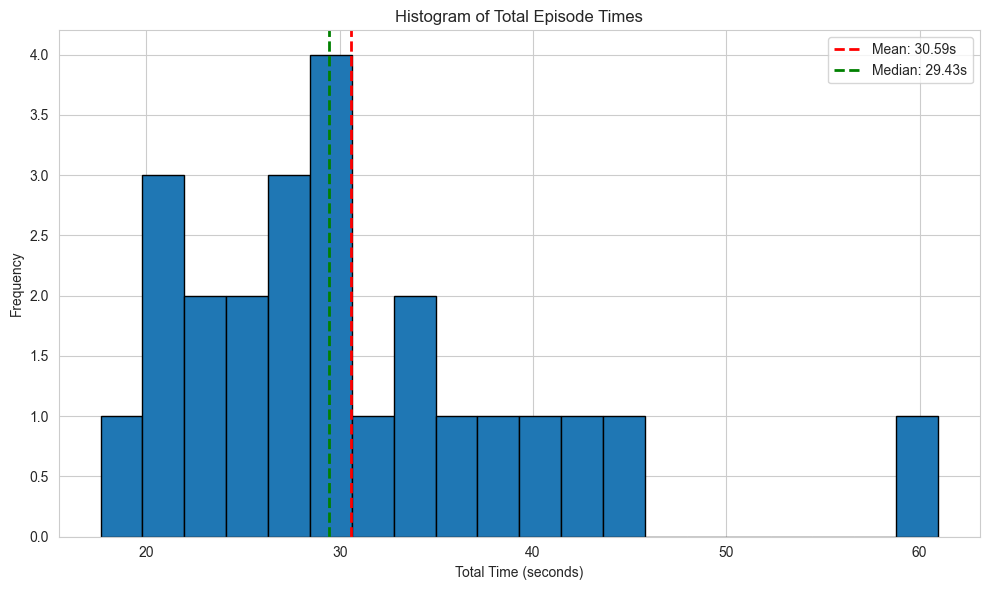

In [292]:
def plot_total_time_histogram(episode_data_list, bins=20, figsize=(10, 6), title="Histogram of Total Episode Times"):
    """
    Creates a histogram of total times for episodes.
    
    Parameters:
    - episode_data_list: List of episode data objects
    - bins: Number of bins for the histogram (default: 20)
    - figsize: Figure size as a tuple (width, height) in inches (default: (10, 6))
    - title: Title for the plot (default: "Histogram of Total Episode Times")
    
    Returns:
    - fig, ax: The figure and axis objects of the plot
    """
    # Calculate total times for each episode
    total_times = [sum(episode.reaction_times[:-1]) / 1000 for episode in episode_data_list]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the histogram
    ax.hist(total_times, bins=bins, edgecolor='black')
    
    # Set labels and title
    ax.set_xlabel("Total Time (seconds)")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    
    # Add some statistics to the plot
    mean_time = np.mean(total_times)
    median_time = np.median(total_times)
    ax.axvline(mean_time, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_time:.2f}s')
    ax.axvline(median_time, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_time:.2f}s')
    
    # Add a legend
    ax.legend()
    
    # Add text with more statistics
    stats_text = f"Mean: {mean_time:.2f}s\nMedian: {median_time:.2f}s\nMin: {min(total_times):.2f}s\nMax: {max(total_times):.2f}s"
    # ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax

user_settings = dict(manipulation=3, eval=True)
idxs = get_user_samples(**user_settings)
eplist = [user_data[idx] for idx in idxs]
plot_total_time_histogram(eplist)

## Manipulation 3

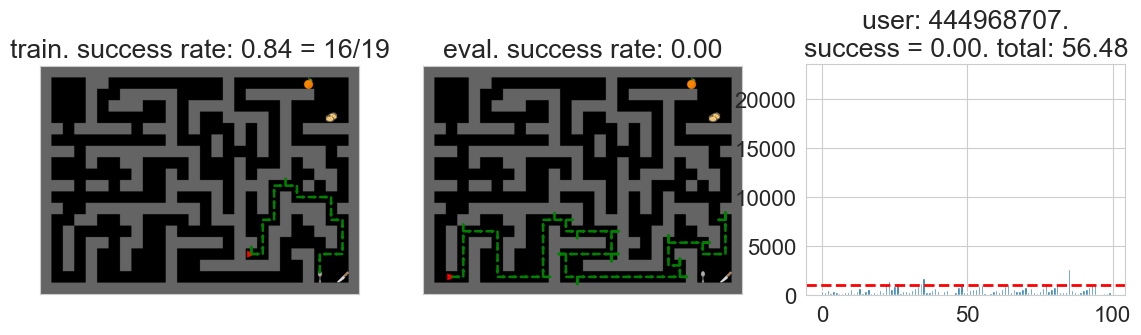

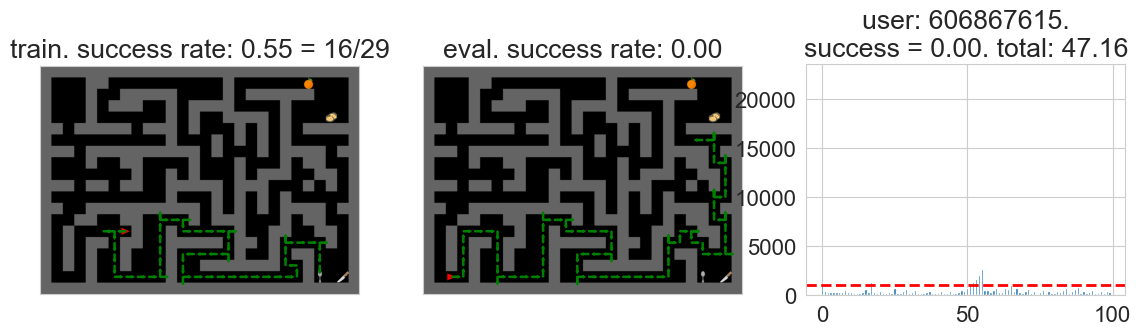

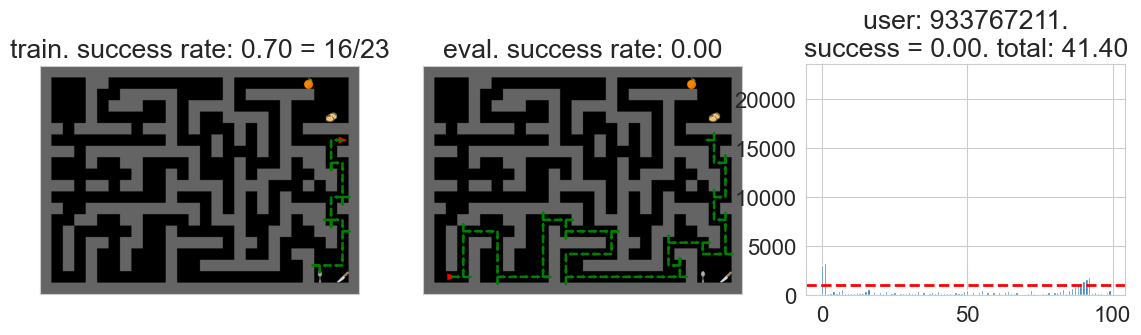

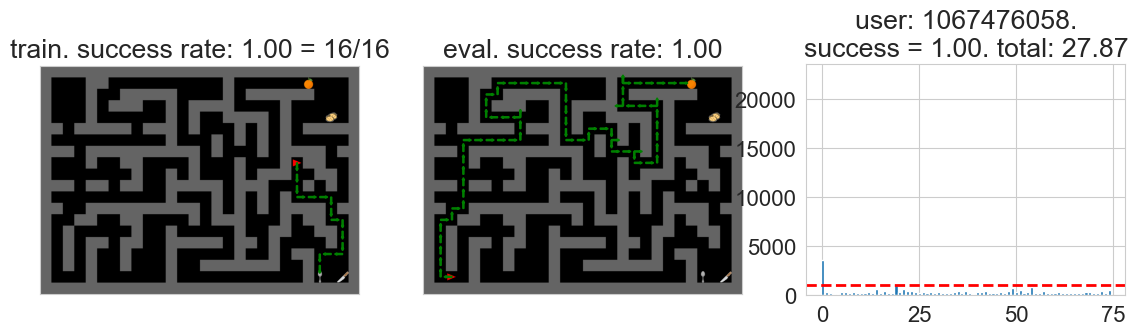

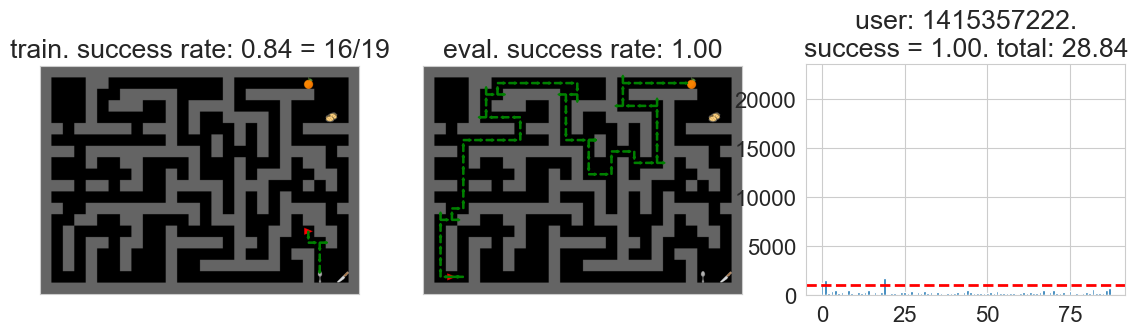

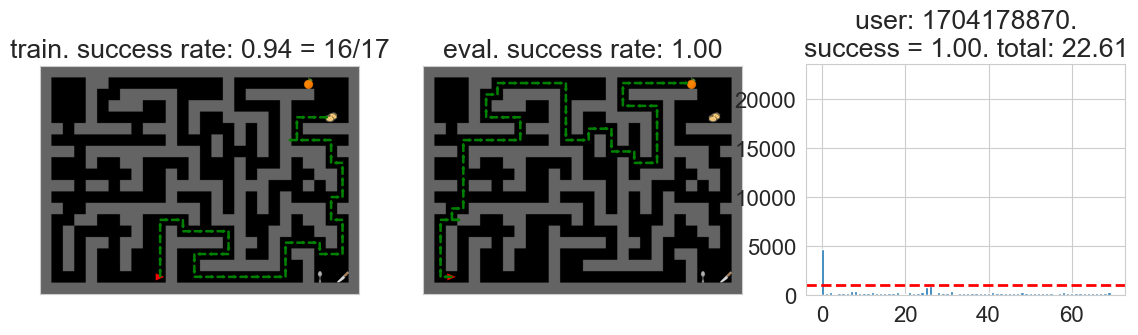

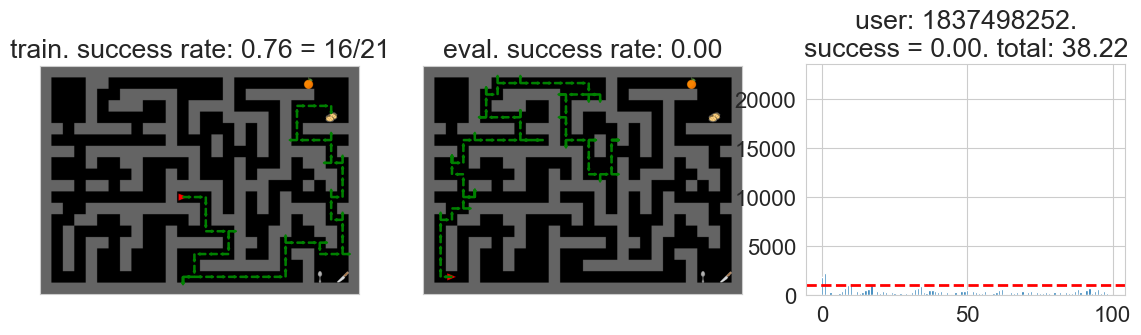

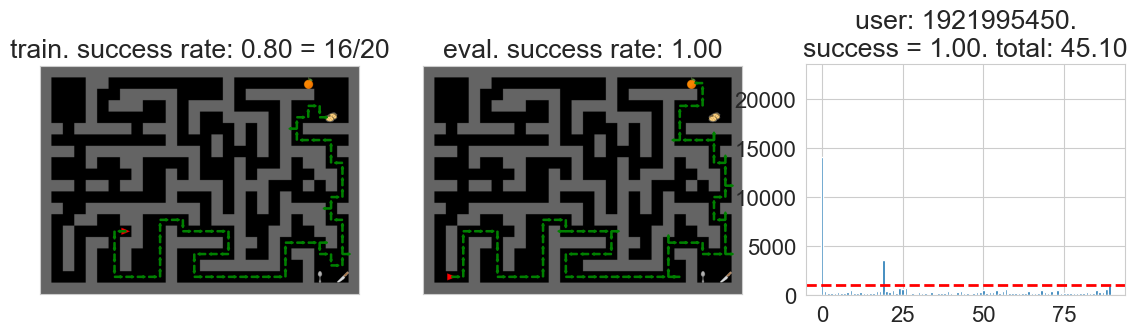

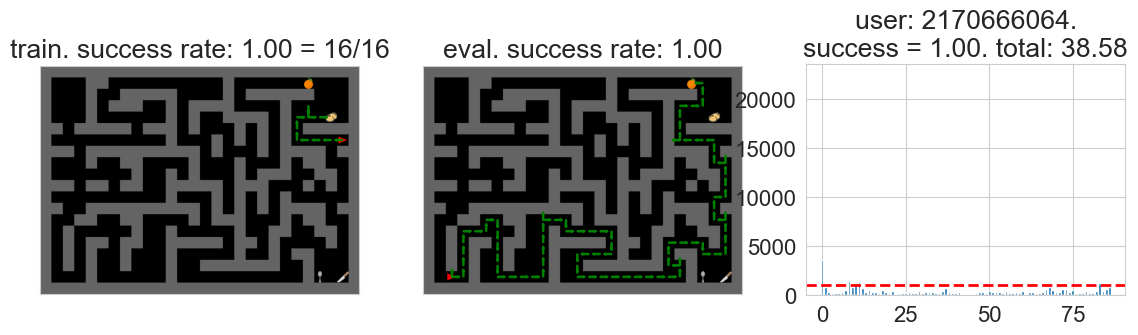

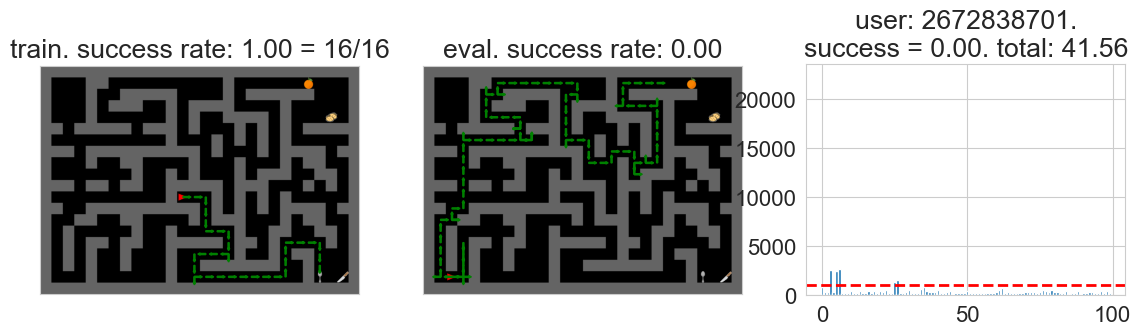

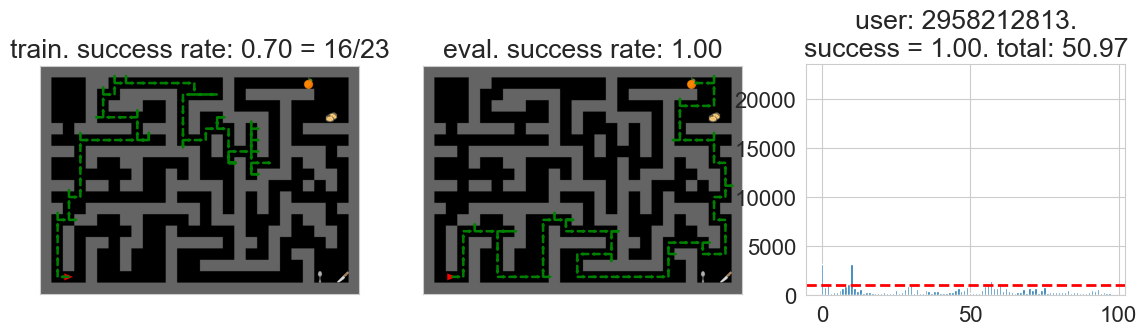

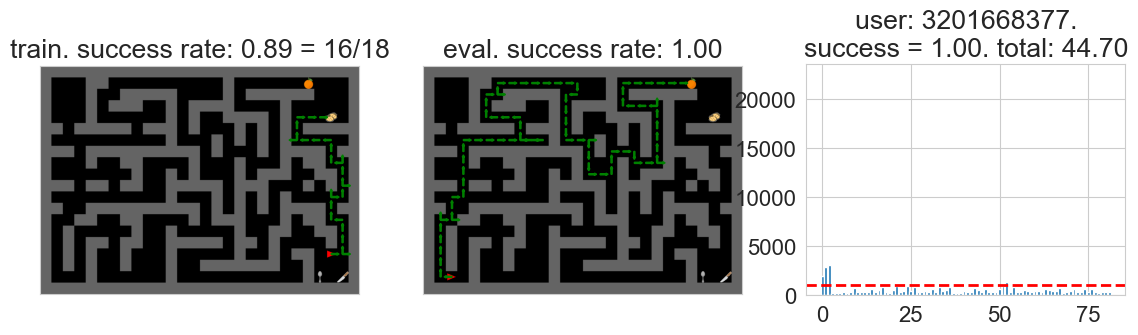

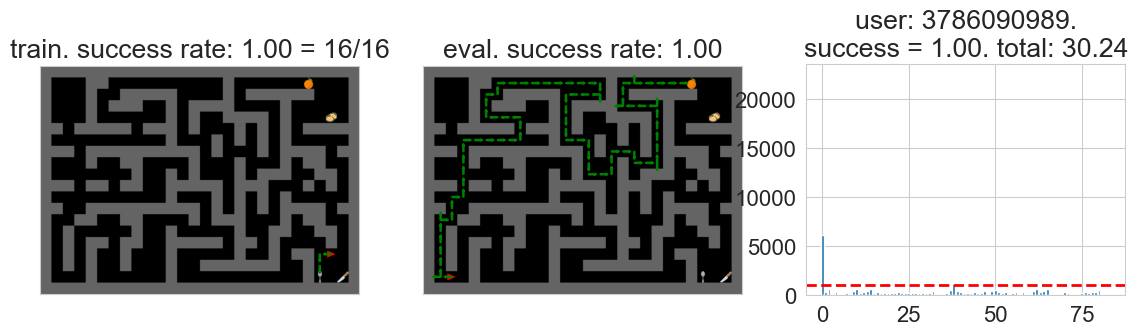

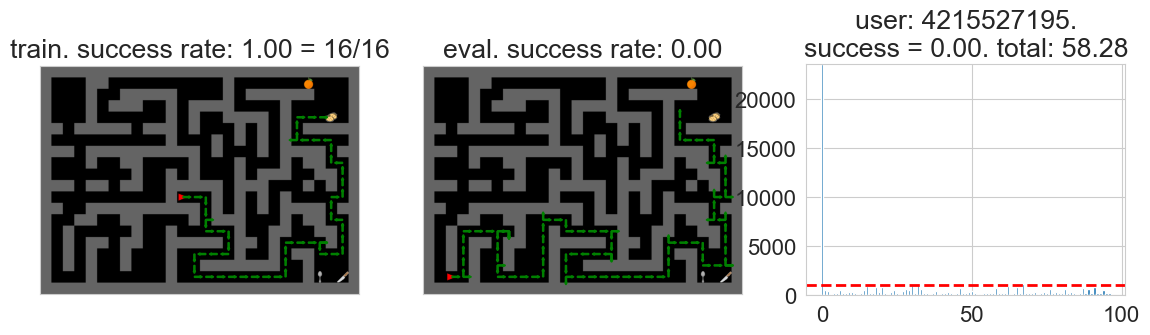

In [61]:
def plot_single_user_reaction_hist(user_id, episode_data, ax=None, y_max=None, flagged=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))

    
    reaction_times = episode_data.reaction_times[:-1]
    seconds = reaction_times / 1000
    total = sum(seconds)

    ax.axhline(y=1000, color='r', linestyle='--', linewidth=2)
    success = housemaze_analysis.success(episode_data) > 0
    ax.bar(np.arange(len(reaction_times)), reaction_times)
    title = f'user: {user_id}.\nsuccess = {success:.2f}. total: {total:.2f}'
    if flagged is not None:
        if user_id in flagged:
            title += "\nflagged=True"
    ax.set_title(title)
    if y_max:
        ax.set_ylim(0, y_max)  # Set the y-axis limit for the plot

users = user_df['user_id'].unique()


idx = 0
y_max = 0
for idx in range(len(users)):
    manipulation = 3
    user_id = users[idx]
    
    user_settings = dict(user_id=user_id, manipulation=3, eval=True)
    episode_data = user_df.filter(**user_settings).episodes[0]
    y_max = max(episode_data.reaction_times[:-1].max(), y_max)

flagged = [
    2407712891,
    2336130608,
    4058664333,
    1852671773
]


for idx in range(len(users)):
    fig, axs = plt.subplots(1, 3, figsize=(14, 3))
    # maze = 'big_m3_maze1'
    manipulation = 3
    user_id = users[idx]

    ######
    # Train
    ######
    user_settings = dict(user_id=user_id, manipulation=3, eval=False)
    episodes = user_df.filter(**user_settings).episodes
    if len(episodes) == 0:
        print(user_id, 'no training')
        continue
    episode_data = episodes[0]

    successes = [housemaze_analysis.success(e) for e in episodes]
    successes = np.array(successes)
    axs[0].set_title(f"train. success rate: {successes.mean():.2f} = {int(successes.sum())}/{len(successes)}")
    housemaze_analysis.render_path(episode_data, ax=axs[0])

    ######
    # Eval
    ######

    user_settings = dict(user_id=user_id, manipulation=3, eval=True)
    episodes = user_df.filter(**user_settings).episodes
    episode_data = episodes[0]
    
    successes = [housemaze_analysis.success(e) for e in episodes]
    successes = np.array(successes).mean()
    axs[1].set_title(f"eval. success rate: {successes:.2f}")
    housemaze_analysis.render_path(episode_data, ax=axs[1])
    
    plot_single_user_reaction_hist(user_id=user_id, episode_data=episode_data, ax=axs[2], flagged=flagged, y_max=y_max)
    plt.show()
    # plots

## Manipulation 2

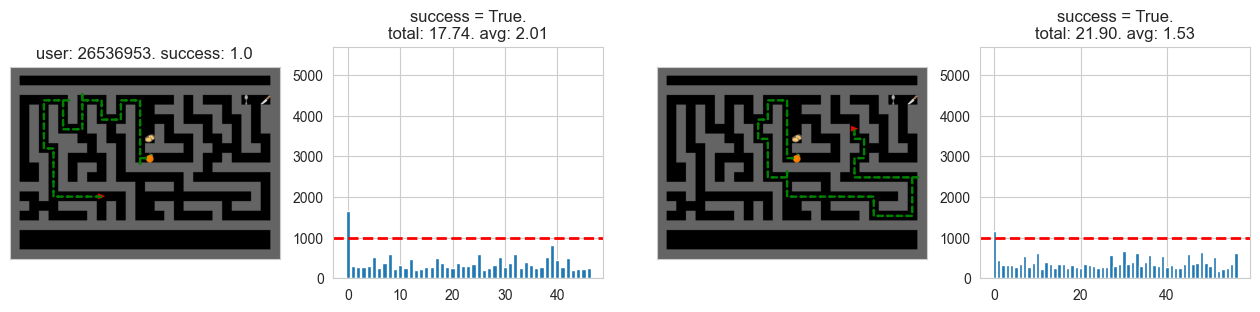

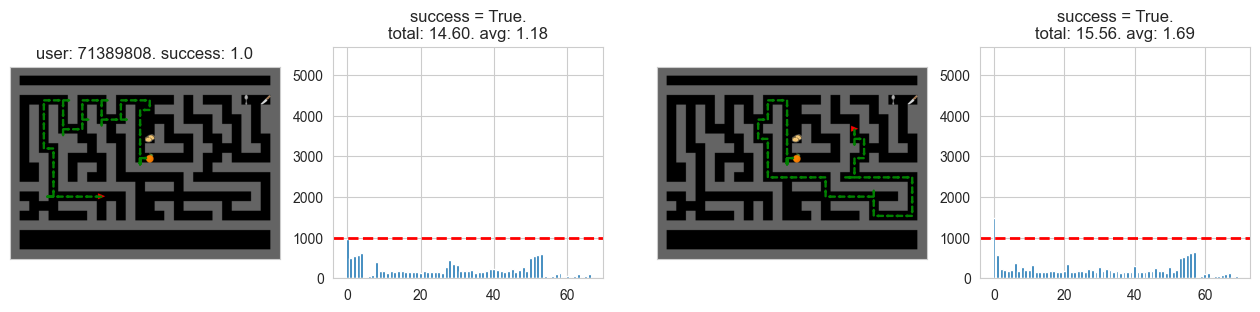

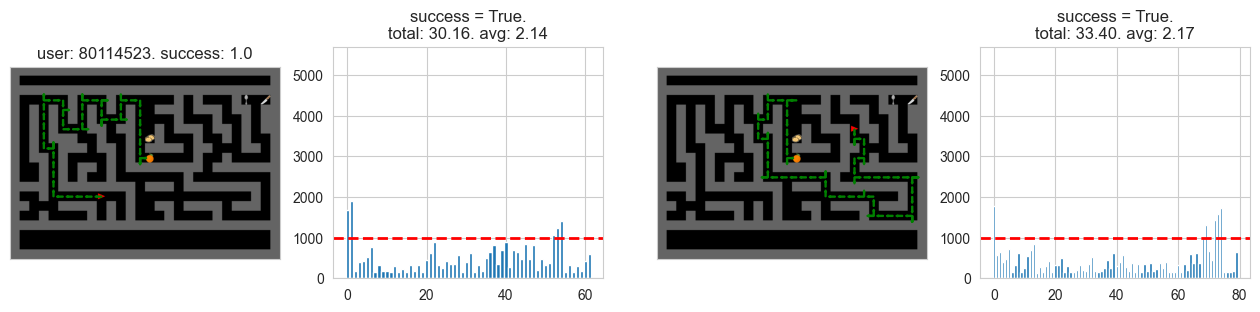

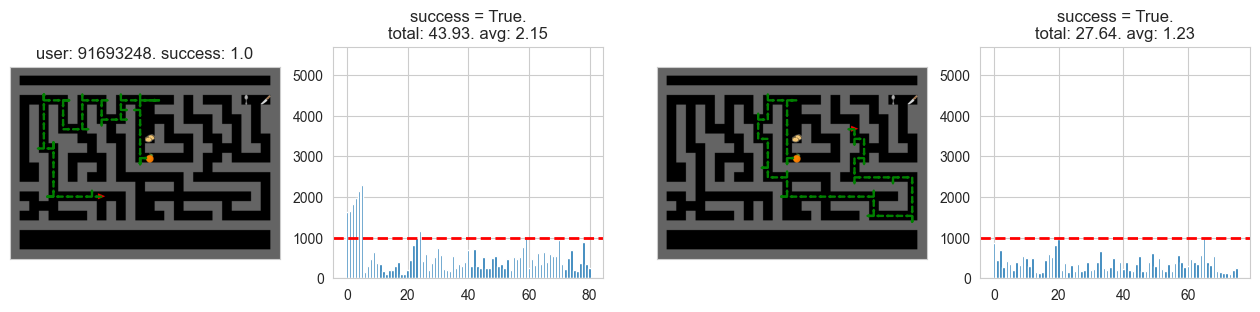

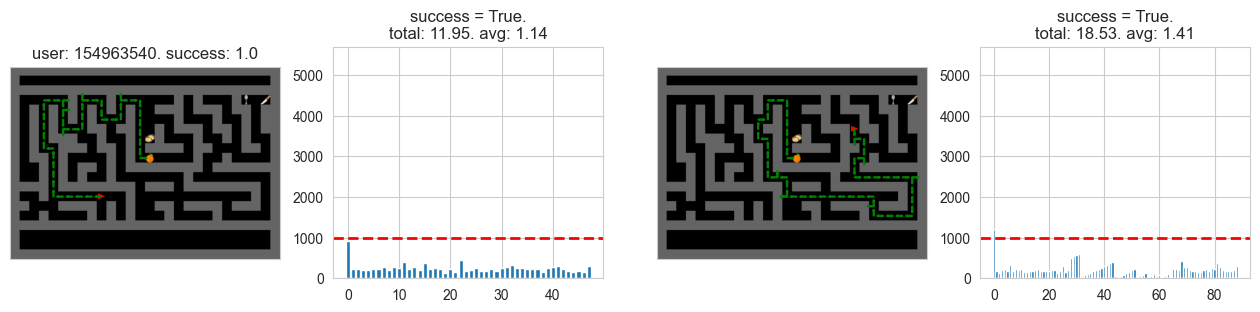

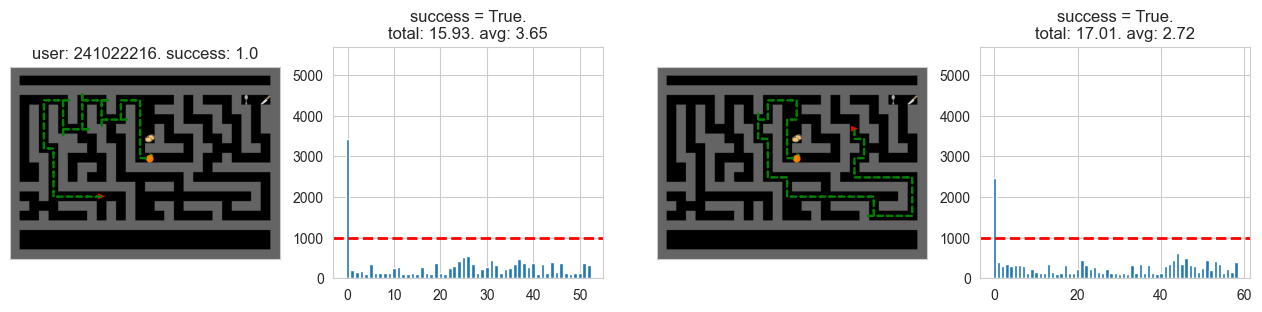

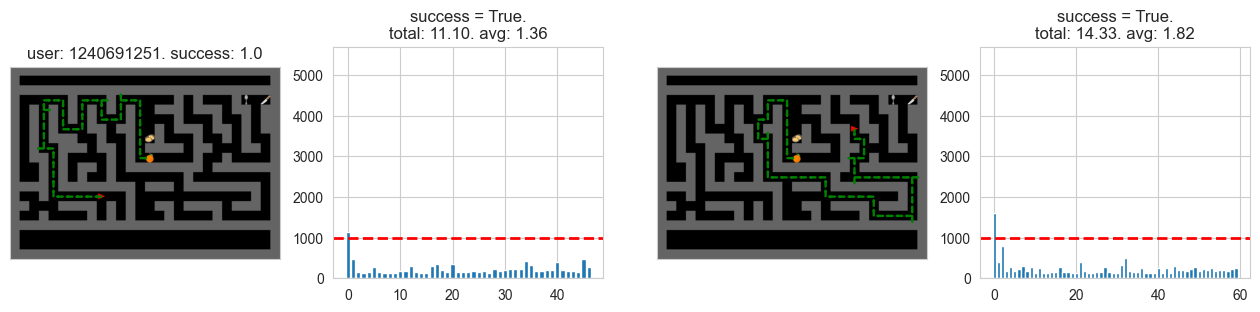

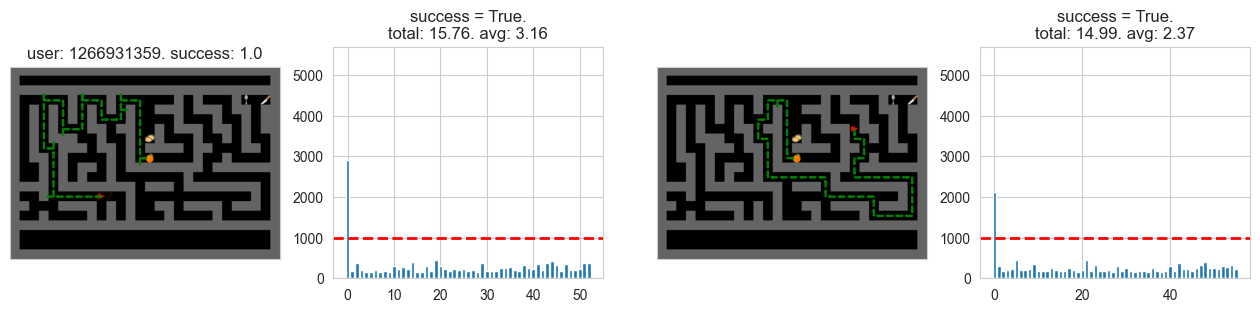

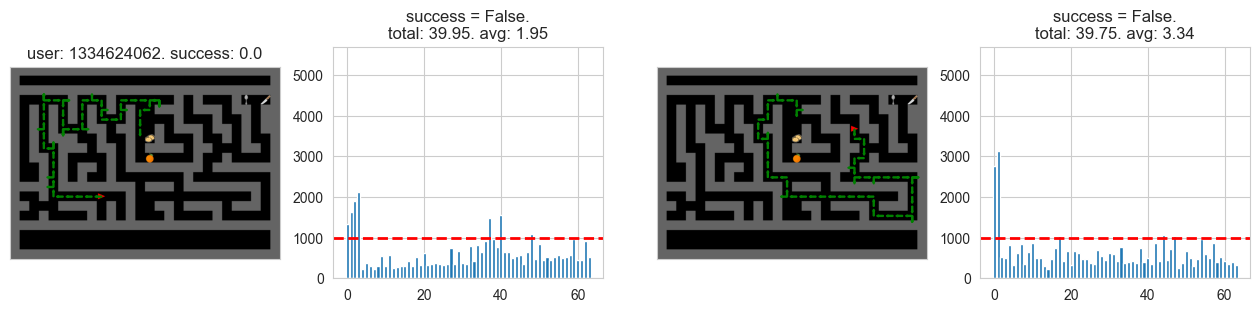

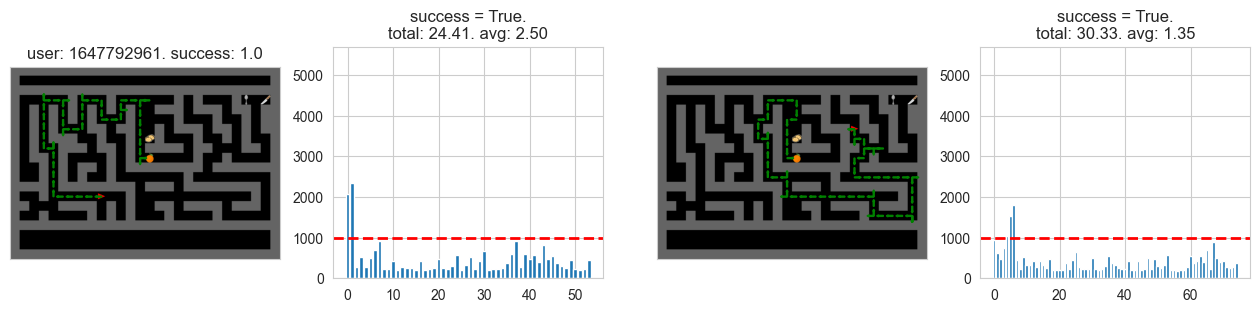

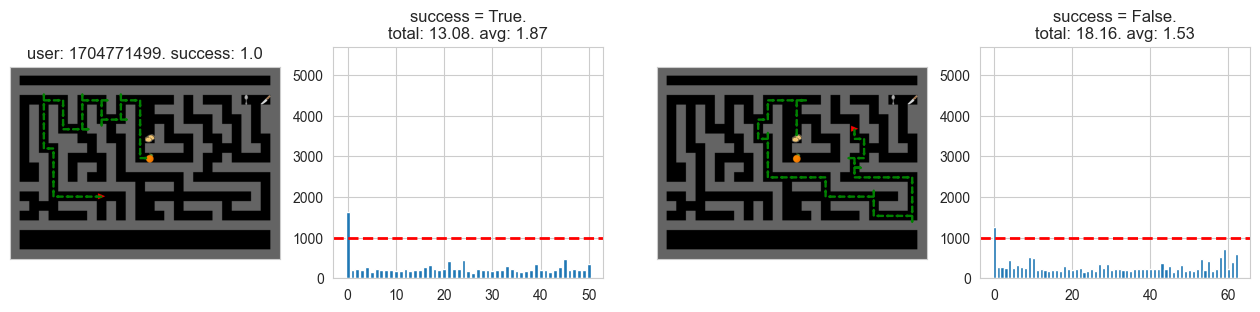

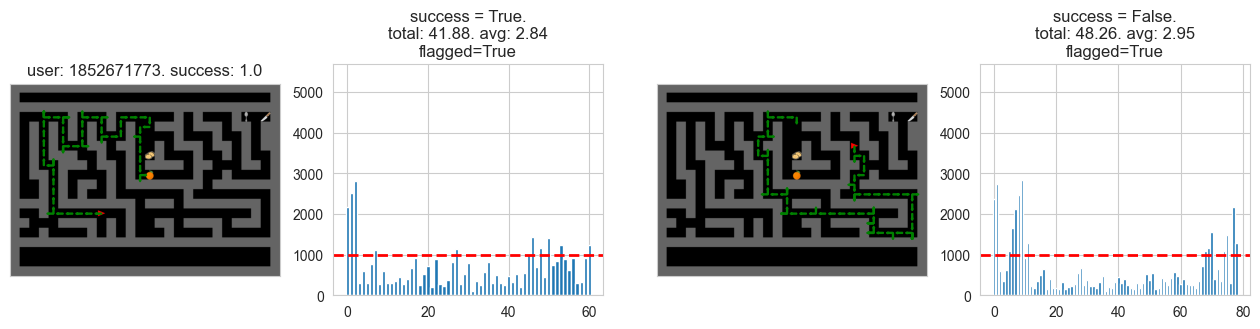

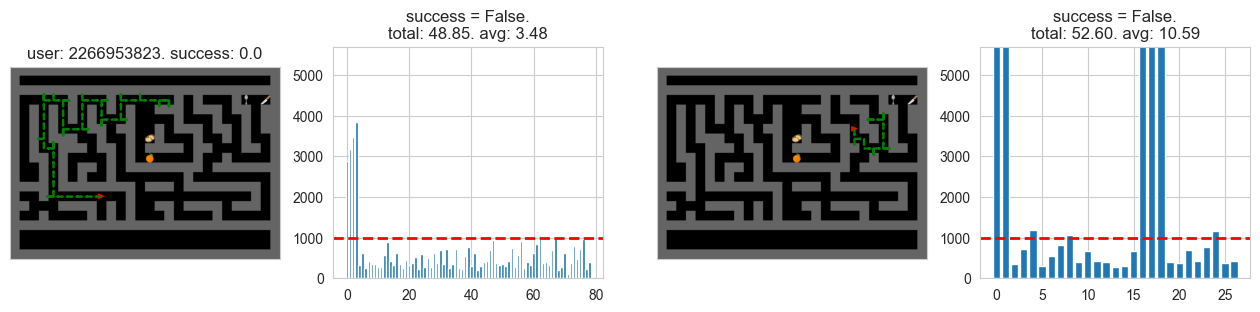

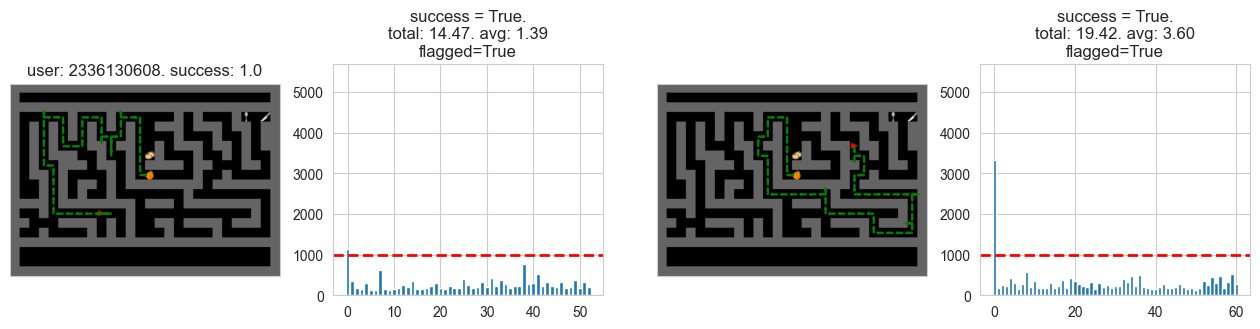

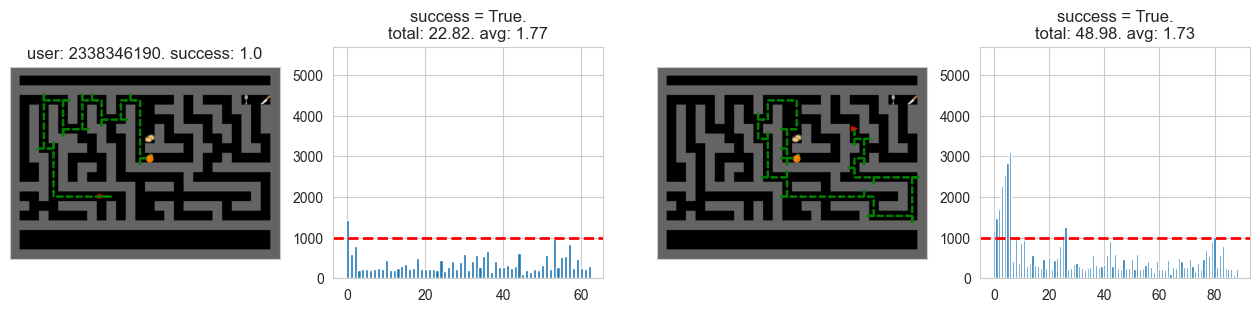

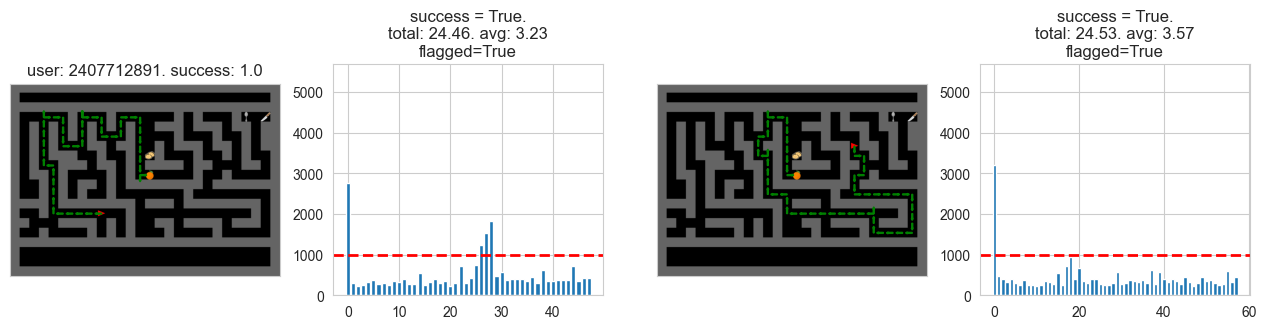

IndexError: index is out of bounds for axis 0 with size 0

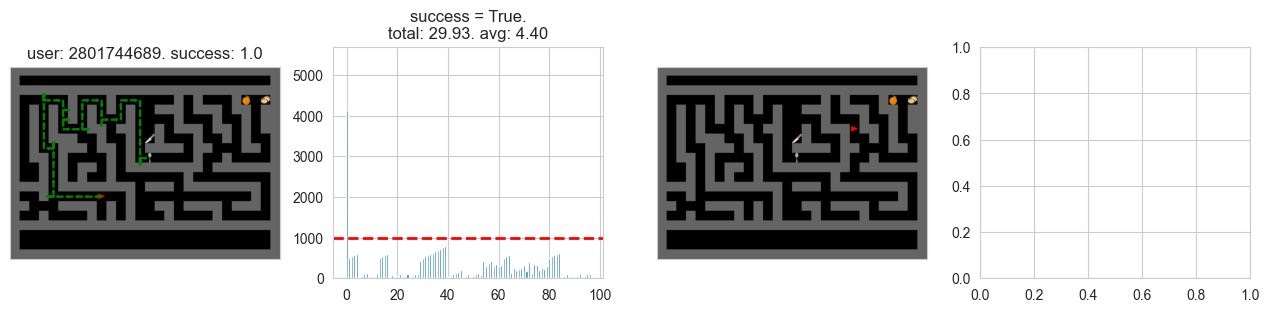

In [325]:
def plot_single_user_reaction_hist(user_id, episode_data, ax=None, y_max=None, flagged=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))

    
    reaction_times = episode_data.reaction_times[:-1]
    seconds = reaction_times / 1000
    total = sum(seconds)
    avg = seconds[0] + seconds[1:].mean()

    
    ax.axhline(y=1000, color='r', linestyle='--', linewidth=2)
    success = housemaze_analysis.success(episode_data) > 0
    ax.bar(np.arange(len(reaction_times)), reaction_times)
    title = f'success = {success}.\ntotal: {total:.2f}. avg: {avg:.2f}'
    if flagged is not None:
        if user_id in flagged:
            title += "\nflagged=True"
    ax.set_title(title)
    if y_max:
        ax.set_ylim(0, y_max)  # Set the y-axis limit for the plot
    


idx = 0
y_max = 0
for idx in range(len(users)):
    manipulation = 2
    user_id = users[idx]
    
    user_settings = dict(user_id=user_id, manipulation=3, eval=True)
    idxs = get_user_samples(**user_settings)
    episode_data = user_data[idxs[0]]
    y_max = max(episode_data.reaction_times[:-1].max(), y_max)

flagged = [
    2407712891,
    2336130608,
    4058664333,
    1852671773
]


for idx in range(len(users)):
    fig, axs = plt.subplots(1, 4, figsize=(16, 3))
    # maze = 'big_m3_maze1'
    manipulation = 3
    user_id = users[idx]

    ######
    # Train
    ######
    
    user_settings = dict(user_id=user_id, manipulation=2, eval=True, stage="new location, off-path")
    idxs = get_user_samples(**user_settings)
    if len(idxs) == 0:
        print(user_id, 'no training')
        continue
    episode_data = user_data[idxs[0]]

    successes = [housemaze_analysis.success(user_data[i]) for i in idxs]
    successes = np.array(successes)
    axs[0].set_title(f"user: {user_id}. success: {successes.mean()}")
    housemaze_analysis.render_path(episode_data, ax=axs[0])

    plot_single_user_reaction_hist(user_id=user_id, episode_data=episode_data, ax=axs[1], flagged=flagged, y_max=y_max)

    ######
    # Eval
    ######

    user_settings = dict(user_id=user_id, manipulation=2, eval=True, stage="new location, on-path")
    idxs = get_user_samples(**user_settings)
    episode_data = user_data[idxs[0]]
    
    successes = [housemaze_analysis.success(user_data[i]) for i in idxs]
    successes = np.array(successes).mean()
    housemaze_analysis.render_path(episode_data, ax=axs[2])
    
    plot_single_user_reaction_hist(user_id=user_id, episode_data=episode_data, ax=axs[3], flagged=flagged, y_max=y_max)
    plt.show()
    # plots

In [178]:
user_df.head()

index,stage,block,manipulation,episode_idx,eval,user_episode_idx,task,room,user_id,age,sex
u32,str,str,i64,i64,bool,i64,i64,i64,i64,i64,str
1,"""training""","""shortcut""",1,1,false,0,13,0,2801744689,45,"""Male"""
2,"""training""","""shortcut""",1,2,false,1,3,1,2801744689,45,"""Male"""
3,"""training""","""shortcut""",1,3,false,2,3,1,2801744689,45,"""Male"""
4,"""training""","""shortcut""",1,4,false,3,3,1,2801744689,45,"""Male"""
5,"""training""","""shortcut""",1,5,false,4,3,1,2801744689,45,"""Male"""
